# Idle States Residency Analysis

In [26]:
import logging
from conf import LisaLogging
LisaLogging.setup(level=100)

In [27]:
%matplotlib inline

import os

# Support to access the remote target
from env import TestEnv

# Support to access cpuidle information from the target
from devlib import *

# Support to configure and run RTApp based workloads
from wlgen import RTA, Ramp

# Support for trace events analysis
from trace import Trace
from trace import ResidencyTime, ResidencyData

# DataFrame support
import pandas as pd
from pandas import DataFrame

# Trappy (plots) support
from trappy import ILinePlot
from trappy.stats.grammar import Parser

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

# Hikey620 Platform Configurations

In [28]:
# Setup target configuration
hikey620_conf = {
    "platform"     : 'generic_linux',
    "board"        : 'hikey960',
    "results_dir"  : "test",
    "modules"      : [ 'cpufreq', 'cpuidle' ],
    "ftrace"       : {
        "events" : [ "cpu_idle", "cpu_capacity", "cpu_frequency", "sched_switch", "sched_load_avg_cpu" ],
        "buffsize" : 100 * 1024,
    },
    "tools"        : [ 'trace-cmd', 'taskset', 'rt-app', 'sysbench' ],
}

In [29]:
hikey620_platform = {
    'kernel': {
        'major': 4,
        'sha1': '78e8b90',
        'version': '57 SMP PREEMPT Sat Jul 1 15:42:00 CST 2017',
        'version_number': 4,
        'parts': [4, 4, 74],
        'rc': None,
        'release': '4.4.74-g78e8b90',
        'minor': 74
    },
    
    'freqs': {
        'big':    [ 280000, 432000, 729000, 960000, 1200000 ],
        'little': [ 280000, 432000, 729000, 960000, 1200000 ]
    },
    
    'nrg_model': {
        'big': {
            'cluster': {
                'nrg_max': 112
            },
            'cpu': {
                'cap_max': 1024,
                'nrg_max': 607
            }
        },
        'little': {
            'cluster': {
                'nrg_max': 112
            },
            'cpu': {
                'cap_max': 1024,
                'nrg_max': 607
            }
        }
    },
    
    'clusters': {
        'big': [4, 5, 6, 7],
        'little': [0, 1, 2, 3]
    },
    'cpus_count': 8,
    'topology': [[0, 1, 2, 3], [4, 5, 6, 7]]
}

# Hikey960 Platform Configurations

In [30]:
# Setup target configuration
hikey960_conf = {
    "platform"     : 'generic_linux',
    "board"        : 'hikey960',
    "results_dir"  : "test",
    "modules"      : [ 'cpufreq', 'cpuidle' ],
    "ftrace"       : {
        "events" : [ "cpu_idle", "cpu_capacity", "cpu_frequency", "sched_switch", "sched_load_avg_cpu" ],
        "buffsize" : 100 * 1024,
    },
    "tools"        : [ 'trace-cmd', 'taskset', 'rt-app', 'sysbench' ],
}

In [31]:
hikey960_platform = {
    'kernel': {
        'major': 4,
        'sha1': '78e8b90',
        'version': '57 SMP PREEMPT Sat Jul 1 15:42:00 CST 2017',
        'version_number': 14,
        'parts': [4, 14, 74],
        'rc': None,
        'release': '4.4.74-g78e8b90',
        'minor': 74
    },
    
    'freqs': {
        'big':    [ 533000,  999000, 1402000, 1709000, 1844000 ],
        'little': [ 903000, 1421000, 1805000, 2112000, 2362000 ]
    },
    
    'nrg_model': {
        'big': {
            'cluster': {
                'nrg_max': 433
            },
            'cpu': {
                'cap_max': 1024,
                'nrg_max': 2848
            }
        },
        'little': {
            'cluster': {
                'nrg_max': 144
            },
            'cpu': {
                'cap_max': 462,
                'nrg_max': 502
            }
        }
    },
    
    'clusters': {
        'big'    : [4, 5, 6, 7],
        'little' : [0, 1, 2, 3]
    },
    'cpus_count': 8,
    'topology': [[0, 1, 2, 3], [4, 5, 6, 7]]
}

# Idle state statistics comparison

## Plot the CPU idle state residency for two data frame in the single picture.  So it's directive for reviewing the difference between two testings. 

In [32]:
def plotCPUIdleStateResidencyComparison(prev_ia, post_ia, cpus=None, pct=False):
    if not prev_ia._trace.hasEvents('cpu_idle'):
        prev_ia._log.warning('Events [cpu_idle] not found, plot DISABLED!')
        return
    
    if not post_ia._trace.hasEvents('cpu_idle'):
        post_ia._log.warning('Events [cpu_idle] not found, plot DISABLED!')
        return
    
    if cpus is None:
        # Generate plots only for available CPUs
        cpuidle_data = prev_ia._dfg_trace_event('cpu_idle')
        _cpus = range(cpuidle_data.cpu_id.max() + 1)
    else:
        _cpus = listify(cpus)
    
    # print _cpus
    
    xmax = 0.0 
    
    prev_residencies = []
    post_residencies = []
    
    for cpu in _cpus:
        r = prev_ia._dfg_cpu_idle_state_residency(cpu)
        prev_residencies.append(ResidencyData('CPU{}'.format(cpu), r)) 

        max_time = r.max().values[0]
        if xmax < max_time:
            xmax = max_time
            
    for cpu in _cpus:
        r = post_ia._dfg_cpu_idle_state_residency(cpu)
        post_residencies.append(ResidencyData('CPU{}'.format(cpu), r)) 

        max_time = r.max().values[0]
        if xmax < max_time:
            xmax = max_time
            
    #print prev_residencies[0]
    #print post_residencies[0]
    
    n_plots = len(prev_residencies) + len(post_residencies)
    gs = gridspec.GridSpec(n_plots, 1)
    fig = plt.figure()

    for i, data in enumerate(prev_residencies):
        
        idx = i * 2
        
        prev_r = prev_residencies[i].residency
        post_r = post_residencies[i].residency
        
        #print prev_r
        #print post_r
        
        if prev_r is None:
            plt.close(fig)
            return
        
        if post_r is None:
            plt.close(fig)
            return
        
        is_first = idx == 0
        is_last  = (idx + 2) == n_plots
            
        axes = fig.add_subplot(gs[idx])

        yrange = 0.4 * max(6, len(r)) * n_plots
        
        if pct:
            duration = prev_r.time.sum()
            r_pct = prev_r.apply(lambda x: x*100/duration)
            r_pct.columns = [data.label]
            r_pct.T.plot.barh(ax=axes, stacked=True, figsize=(16, yrange))

            axes.legend(loc='lower center', ncol=7)
            axes.set_xlim(0, 100)
        else:
            prev_r.plot.barh(ax=axes, color='b',
                        legend=False, figsize=(16, yrange))

            axes.set_xlim(0, 1.05*xmax)
            axes.set_ylabel('Idle State')
            axes.set_title(data.label + ": Before Optimization")

        axes.grid(True)
        axes.set_xticklabels([])

        if is_first:
            legend_y = axes.get_ylim()[1]
            axes.annotate('Idle State Residency Time Comparison', xy=(0, legend_y),
                              xytext=(-50, 45), textcoords='offset points',
                              fontsize=18)
            
        axes = fig.add_subplot(gs[idx+1])

        yrange = 0.4 * max(6, len(r)) * n_plots
        
        if pct:
            duration = post_r.time.sum()
            r_pct = post_r.apply(lambda x: x*100/duration)
            r_pct.columns = [data.label]
            r_pct.T.plot.barh(ax=axes, stacked=True, figsize=(16, yrange))

            axes.legend(loc='lower center', ncol=7)
            axes.set_xlim(0, 100)
        else:
            post_r.plot.barh(ax=axes, color='g',
                        legend=False, figsize=(16, yrange))

            axes.set_xlim(0, 1.05*xmax)
            axes.set_ylabel('Idle State')
            axes.set_title(data.label + ": After Optimization")

        axes.grid(True)
        if is_last:
            if pct:
                axes.set_xlabel('Residency [%]')
            else:
                axes.set_xlabel('Time [s]')
        else:
            axes.set_xticklabels([])

## Print out data frame table for idle state difference

In [33]:
def dfCPUIdleStateResidencyComparison(prev_ia, post_ia):
    df = pd.DataFrame(columns=('index', 'state0', 'state1', 'state2'))

    if not prev_ia._trace.hasEvents('cpu_idle'):
        prev_ia._log.warning('Events [cpu_idle] not found, plot DISABLED!')
        return
    
    if not post_ia._trace.hasEvents('cpu_idle'):
        post_ia._log.warning('Events [cpu_idle] not found, plot DISABLED!')
        return
    
    # Generate plots only for available CPUs
    cpuidle_data = prev_ia._dfg_trace_event('cpu_idle')
    _cpus = range(cpuidle_data.cpu_id.max() + 1)
    
    xmax = 0.0 
    
    prev_residencies = []
    post_residencies = []
    
    for cpu in _cpus:
        r = prev_ia._dfg_cpu_idle_state_residency(cpu)
        prev_residencies.append(ResidencyData('CPU{}'.format(cpu), r)) 

        max_time = r.max().values[0]
        if xmax < max_time:
            xmax = max_time
            
    for cpu in _cpus:
        r = post_ia._dfg_cpu_idle_state_residency(cpu)
        post_residencies.append(ResidencyData('CPU{}'.format(cpu), r)) 

        max_time = r.max().values[0]
        if xmax < max_time:
            xmax = max_time
            
    for i, data in enumerate(prev_residencies):
        
        idx = i * 2
        
        prev_r = prev_residencies[i].residency
        post_r = post_residencies[i].residency
        diff_r = post_r - prev_r
        
        df = df.append({'index': data.label+"(orig)", 'state0': prev_r['time'][0],
                        'state1': prev_r['time'][1], 'state2': prev_r['time'][2]}, ignore_index=True)
        df = df.append({'index': data.label+"(opt)", 'state0': post_r['time'][0],
                        'state1': post_r['time'][1], 'state2': post_r['time'][2]}, ignore_index=True)
        df = df.append({'index': data.label+"(delta)", 'state0': diff_r['time'][0],
                        'state1': diff_r['time'][1], 'state2': diff_r['time'][2]}, ignore_index=True)            
    return df

# Idle state estimation statistics (Check if break residency)

In [34]:
def dfCPUIdleStateEstimationStatistics(ia, cpu, residency):
    
    #residency = residency / 1000000
    
    idle_df = ia._dfg_trace_event('cpu_idle')
    cpu_idle = idle_df[idle_df.cpu_id == cpu]

    # Generate valid idle states
    available_idles = sorted(idle_df.state.unique())
    available_idles = available_idles[1:]

    cpu_is_idle = ia._trace.getCPUActiveSignal(cpu) ^ 1
    cpu_idle = cpu_idle.join(cpu_is_idle.to_frame(name='is_idle'),
                                 how='outer')
    cpu_idle.fillna(method='ffill', inplace=True)

    idle_time = pd.DataFrame({'over_est' : 0, 'under_est' : 0, 'good_est' : 0, 'cpu' : 0}, index=available_idles)

    for i in available_idles:
        idle_state = cpu_idle.state.apply(
            lambda x: 1 if x == i else 0
        )
        #print idle_state
        idle_t = cpu_idle.is_idle * idle_state
        #print idle_t
        # Compute total time by integrating the square wave
        #print ia._trace.integrate_square_wave(idle_t)
        idle_t.iloc[-1] = 0.0

        # Compact signal to obtain only 1-0-1-0 sequences
        comp_sig = idle_t.loc[idle_t.shift() != idle_t]
        #print comp_sig
        if comp_sig.iloc[0] == 0.0:
            idle_interval = (comp_sig.iloc[2::2].index - comp_sig.iloc[1:-1:2].index)
        else:
            idle_interval = (comp_sig.iloc[1::2].index - comp_sig.iloc[:-1:2].index)
        
        idle_interval *= 1000000
        
        idle_time.at[i, 'cpu']  = cpu
        idle_time.at[i, 'over_est']  = len(idle_interval[idle_interval < residency[i]])
        idle_time.at[i, 'under_est'] = len(idle_interval[idle_interval > residency[i+1]])
        idle_time.at[i, 'good_est']  = len(idle_interval[(idle_interval >= residency[i]) & (idle_interval < residency[i+1])])          
        
    return idle_time

In [35]:
from collections import namedtuple

ResidencyTimes = namedtuple('ResidencyTimes', ['label', 'stats'])

def dfAllCPUIdleStateEstimationStatistics(ia, residency, cpus=None):

    if not ia._trace.hasEvents('cpu_idle'):
        ia._log.warning('Events [cpu_idle] not found, '
                        'plot DISABLED!')
        return

    if cpus is None:
        # Generate plots only for available CPUs
        cpuidle_data = ia._dfg_trace_event('cpu_idle')
        _cpus = range(cpuidle_data.cpu_id.max() + 1)
    else:
        _cpus = listify(cpus)

    # Generate valid idle states
    idle_df = ia._dfg_trace_event('cpu_idle')
    available_idles = sorted(idle_df.state.unique())
    available_idles = available_idles[1:]
    
    residencies = pd.DataFrame()
    total_r = pd.DataFrame({'over_est' : 0, 'under_est' : 0, 'good_est' : 0, 'cpu' : -1}, index=available_idles)
    for cpu in _cpus:
        r = dfCPUIdleStateEstimationStatistics(ia, cpu, residency)
        residencies = pd.concat([residencies, r])
        total_r['over_est']  = total_r['over_est']  + r['over_est']
        total_r['under_est'] = total_r['under_est'] + r['under_est']
        total_r['good_est']  = total_r['good_est']  + r['good_est']
        
    residencies = pd.concat([residencies, total_r])
    return residencies

In [36]:
def dfAllCPUIdleStateEstimationStatisticsDiff(prev_ia, post_ia, residency):
    
    prev_df = dfAllCPUIdleStateEstimationStatistics(prev_ia, residency)
    post_df = dfAllCPUIdleStateEstimationStatistics(post_ia, residency)
    merge_df = pd.concat([prev_df, post_df], axis=1)
    est_diff = post_df - prev_df
    est_df = pd.concat([merge_df, est_diff], axis=1)
    return est_df

# Test case 1: Period: 10ms, dutycycle: 1%

## Read trace data

In [37]:
res_dir = '/home/leoy/Work2/Develop/tools/lisa/results/cpuidle_prev_opt/example_10ms_1pct'
trace_file = os.path.join(res_dir, "trace.dat")
prev_trace = Trace(hikey620_platform, trace_file, events=hikey620_conf['ftrace']['events'], normalize_time=True)
prev_ia = prev_trace.analysis.idle

In [38]:
res_dir = '/home/leoy/Work2/Develop/tools/lisa/results/cpuidle_post_opt/example_10ms_1pct'
trace_file = os.path.join(res_dir, "trace.dat")
post_trace = Trace(hikey620_platform, trace_file, events=hikey620_conf['ftrace']['events'], normalize_time=True)
post_ia = post_trace.analysis.idle

## Plot idle states residency comparison

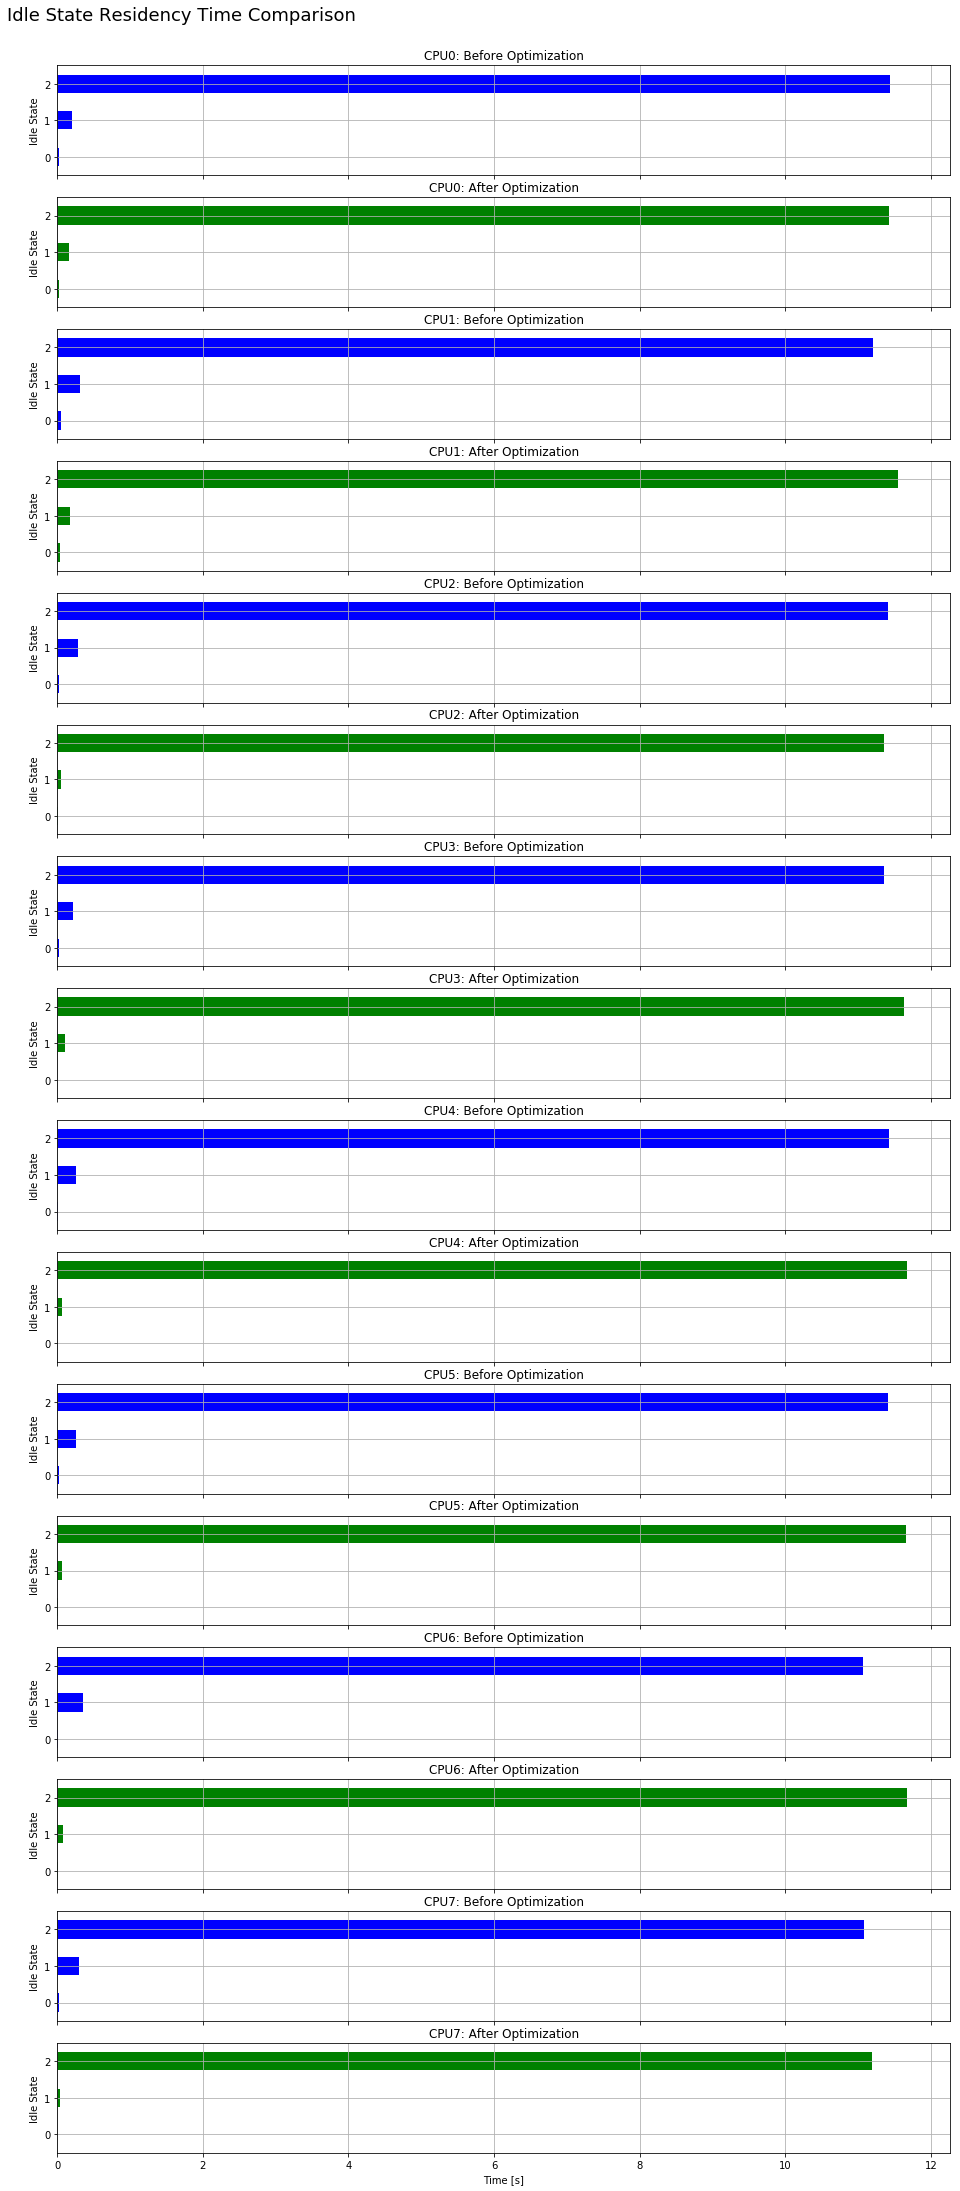

In [39]:
plotCPUIdleStateResidencyComparison(prev_ia, post_ia)

## Idle state estimation statistics (break residency)

In [40]:
df = dfAllCPUIdleStateEstimationStatisticsDiff(prev_ia, post_ia, [ 1, 1000, 2700, 10000000000 ])
df

,cpu,good_est,over_est,under_est,cpu,good_est,over_est,under_est,cpu,good_est,over_est,under_est
0,0,93,0,8,0,56,0,7,0,-37,0,-1
1,0,5,23,48,0,15,44,34,0,10,21,-14
2,0,91,65,0,0,78,83,0,0,-13,18,0
0,1,42,0,17,1,39,0,12,0,-3,0,-5
1,1,15,20,71,1,14,29,36,0,-1,9,-35
2,1,562,34,0,1,46,33,0,0,-516,-1,0
0,2,33,0,10,2,25,0,1,0,-8,0,-9
1,2,15,33,64,2,13,5,8,0,-2,-28,-56
2,2,125,19,0,2,1092,35,0,0,967,16,0
0,3,26,0,7,3,9,0,1,0,-17,0,-6


# Test case2: Period: 10ms, dutycycle: 3%

In [41]:
res_dir = '/home/leoy/Work2/Develop/tools/lisa/results/cpuidle_prev_opt/example_10ms_3pct'
trace_file = os.path.join(res_dir, "trace.dat")
prev_trace = Trace(hikey620_platform, trace_file, events=hikey620_conf['ftrace']['events'], normalize_time=True)
prev_ia = prev_trace.analysis.idle

res_dir = '/home/leoy/Work2/Develop/tools/lisa/results/cpuidle_post_opt/example_10ms_3pct'
trace_file = os.path.join(res_dir, "trace.dat")
post_trace = Trace(hikey620_platform, trace_file, events=hikey620_conf['ftrace']['events'], normalize_time=True)
post_ia = post_trace.analysis.idle

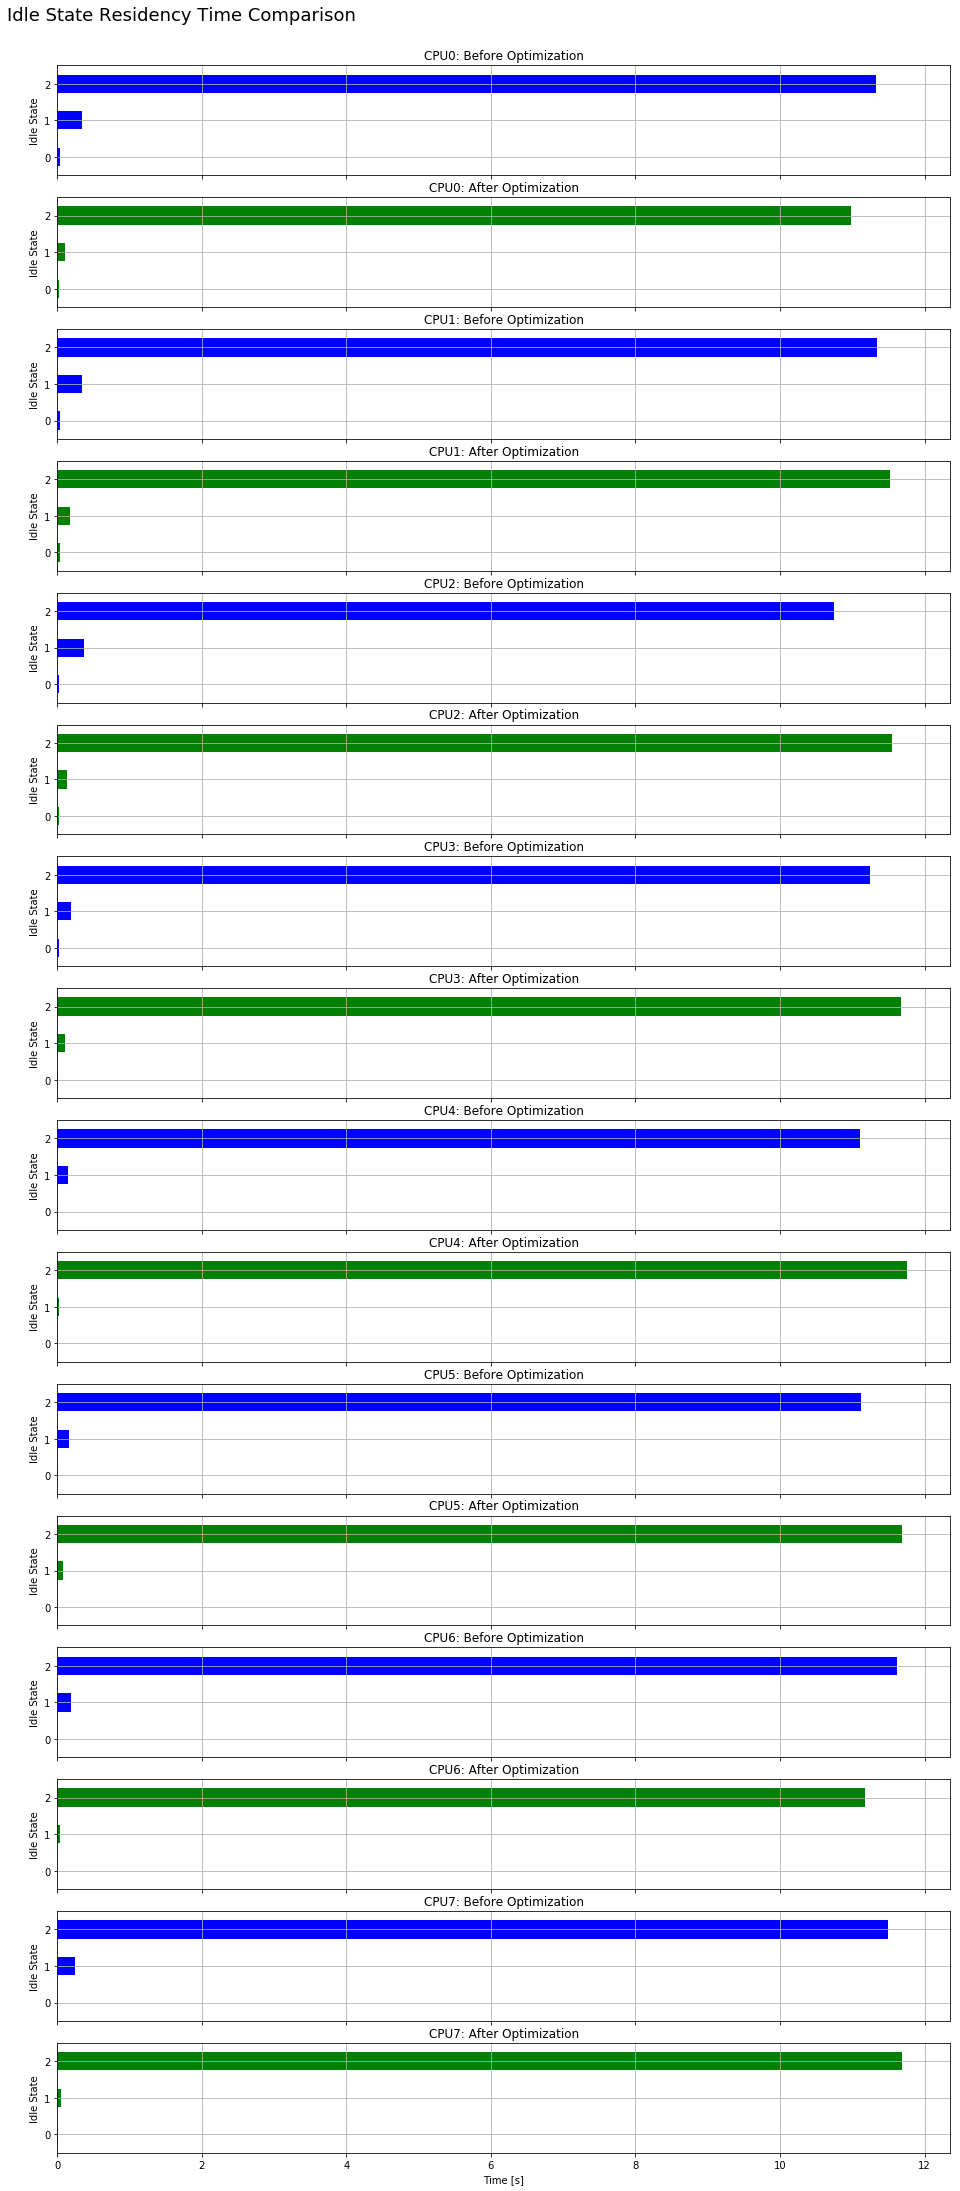

In [42]:
plotCPUIdleStateResidencyComparison(prev_ia, post_ia)

In [43]:
df = dfAllCPUIdleStateEstimationStatisticsDiff(prev_ia, post_ia, [ 1, 1000, 2700, 10000000000 ])
df

,cpu,good_est,over_est,under_est,cpu,good_est,over_est,under_est,cpu,good_est,over_est,under_est
0,0,67,0,13,0,50,0,5,0,-17,0,-8
1,0,9,54,79,0,14,33,19,0,5,-21,-60
2,0,93,61,0,0,1085,77,0,0,992,16,0
0,1,36,0,20,1,48,0,11,0,12,0,-9
1,1,26,35,73,1,20,29,34,0,-6,-6,-39
2,1,53,35,0,1,56,40,0,0,3,5,0
0,2,55,0,5,2,27,0,9,0,-28,0,4
1,2,15,13,91,2,7,15,31,0,-8,2,-60
2,2,1065,20,0,2,105,32,0,0,-960,12,0
0,3,24,0,10,3,20,0,4,0,-4,0,-6


# Test case3: Period: 10ms, dutycycle: 5%

In [44]:
res_dir = '/home/leoy/Work2/Develop/tools/lisa/results/cpuidle_prev_opt/example_10ms_5pct'
trace_file = os.path.join(res_dir, "trace.dat")
prev_trace = Trace(hikey620_platform, trace_file, events=hikey620_conf['ftrace']['events'], normalize_time=True)
prev_ia = prev_trace.analysis.idle

res_dir = '/home/leoy/Work2/Develop/tools/lisa/results/cpuidle_post_opt/example_10ms_5pct'
trace_file = os.path.join(res_dir, "trace.dat")
post_trace = Trace(hikey620_platform, trace_file, events=hikey620_conf['ftrace']['events'], normalize_time=True)
post_ia = post_trace.analysis.idle

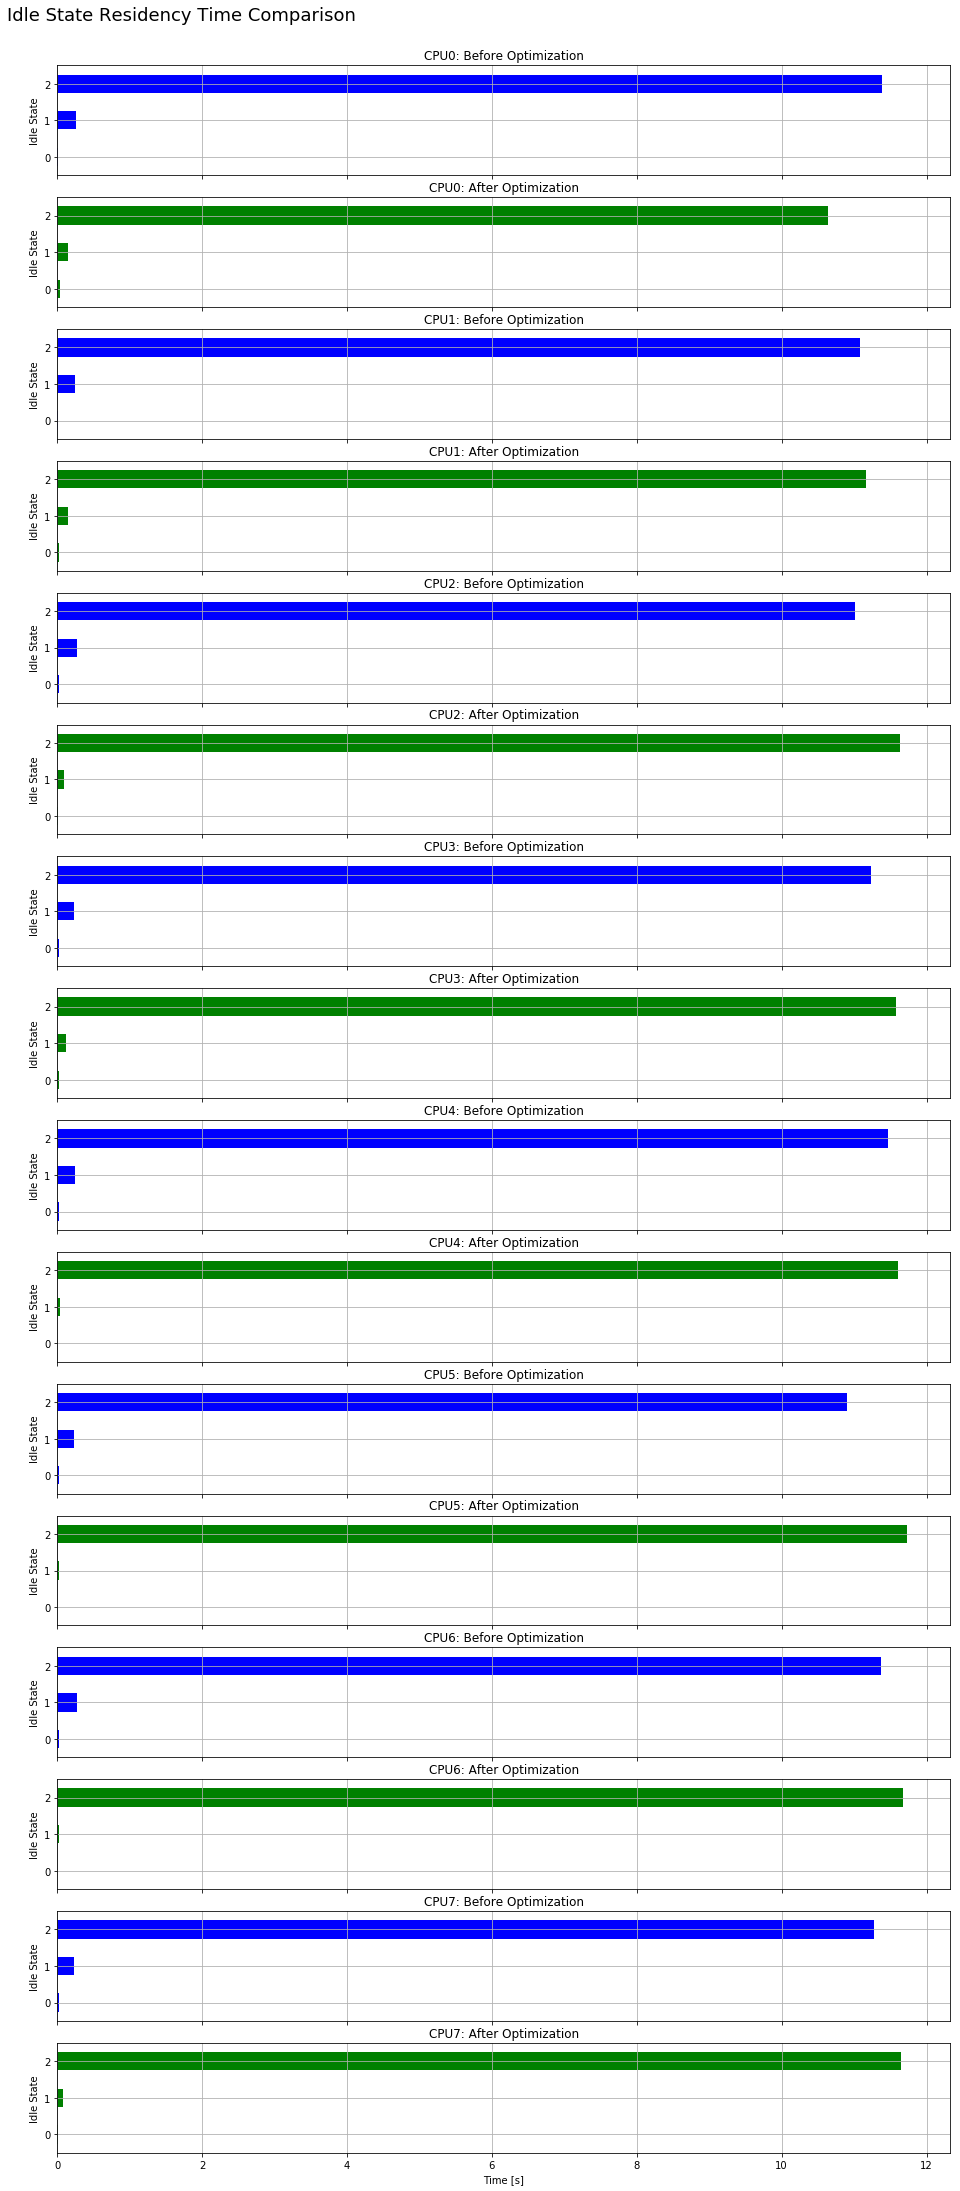

In [45]:
plotCPUIdleStateResidencyComparison(prev_ia, post_ia)

In [46]:
df = dfAllCPUIdleStateEstimationStatisticsDiff(prev_ia, post_ia, [ 1, 1000, 2700, 10000000000 ])
df

,cpu,good_est,over_est,under_est,cpu,good_est,over_est,under_est,cpu,good_est,over_est,under_est
0,0,15,0,5,0,150,0,9,0,135,0,4
1,0,11,12,62,0,16,38,31,0,5,26,-31
2,0,85,168,0,0,1084,72,0,0,999,-96,0
0,1,5,0,2,1,37,0,8,0,32,0,6
1,1,10,4,58,1,14,27,30,0,4,23,-28
2,1,168,9,0,1,294,19,0,0,126,10,0
0,2,33,0,7,2,26,0,3,0,-7,0,-4
1,2,20,10,59,2,5,15,21,0,-15,5,-38
2,2,612,20,0,2,72,37,0,0,-540,17,0
0,3,15,0,11,3,32,0,5,0,17,0,-6


# Test case4: Period: 10ms, dutycycle: 10%

In [47]:
res_dir = '/home/leoy/Work2/Develop/tools/lisa/results/cpuidle_prev_opt/example_10ms_10pct'
trace_file = os.path.join(res_dir, "trace.dat")
prev_trace = Trace(hikey620_platform, trace_file, events=hikey620_conf['ftrace']['events'], normalize_time=True)
prev_ia = prev_trace.analysis.idle

res_dir = '/home/leoy/Work2/Develop/tools/lisa/results/cpuidle_post_opt/example_10ms_10pct'
trace_file = os.path.join(res_dir, "trace.dat")
post_trace = Trace(hikey620_platform, trace_file, events=hikey620_conf['ftrace']['events'], normalize_time=True)
post_ia = post_trace.analysis.idle

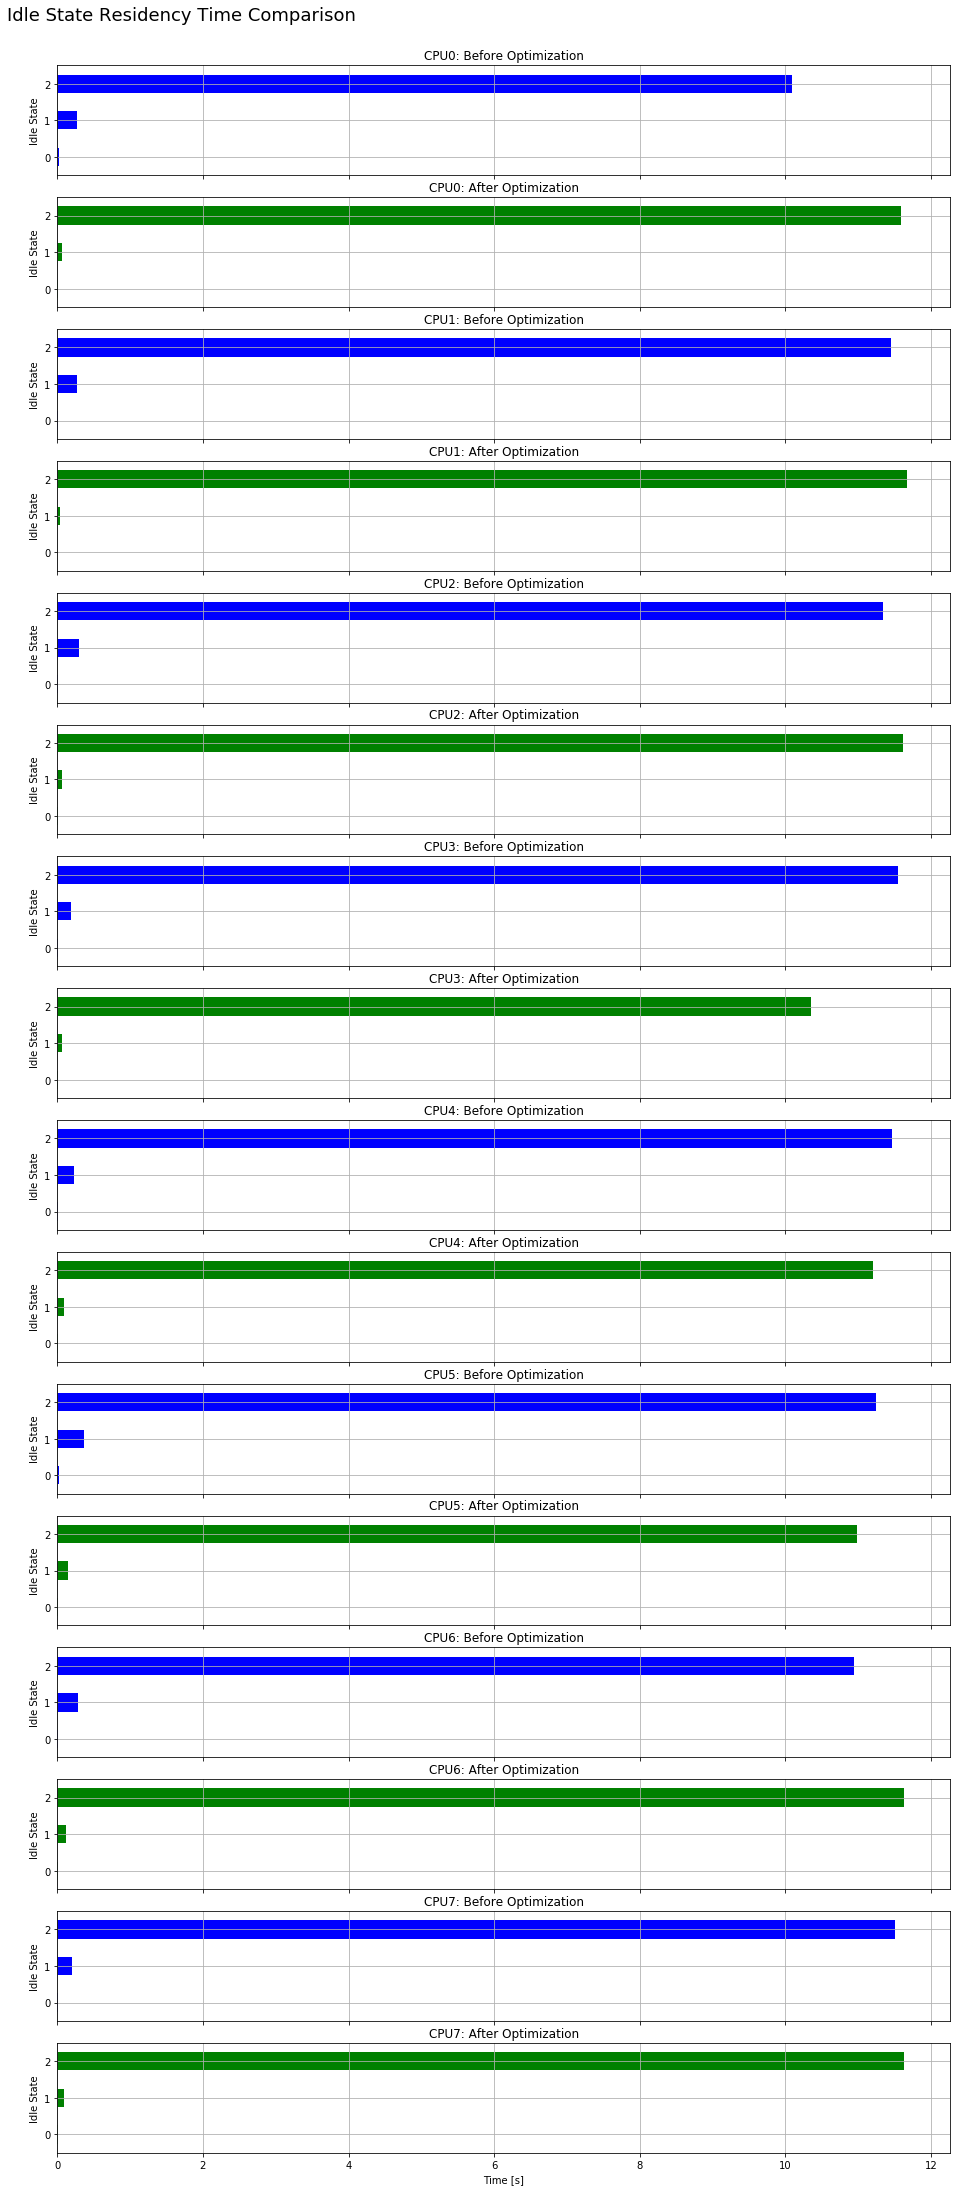

In [48]:
plotCPUIdleStateResidencyComparison(prev_ia, post_ia)

In [49]:
df = dfAllCPUIdleStateEstimationStatisticsDiff(prev_ia, post_ia, [ 1, 1000, 2700, 10000000000 ])
df

,cpu,good_est,over_est,under_est,cpu,good_est,over_est,under_est,cpu,good_est,over_est,under_est
0,0,33,0,11,0,18,0,3,0,-15,0,-8
1,0,12,32,64,0,8,12,15,0,-4,-20,-49
2,0,1066,88,0,0,352,105,0,0,-714,17,0
0,1,12,0,5,1,5,0,1,0,-7,0,-4
1,1,17,7,63,1,6,1,9,0,-11,-6,-54
2,1,55,10,0,1,106,27,0,0,51,17,0
0,2,16,0,4,2,11,0,2,0,-5,0,-2
1,2,9,8,72,2,12,11,10,0,3,3,-62
2,2,86,12,0,2,82,23,0,0,-4,11,0
0,3,5,0,3,3,21,0,0,0,16,0,-3


# Test case5: Period: 10ms, dutycycle: 20%

In [50]:
res_dir = '/home/leoy/Work2/Develop/tools/lisa/results/cpuidle_prev_opt/example_10ms_20pct'
trace_file = os.path.join(res_dir, "trace.dat")
prev_trace = Trace(hikey620_platform, trace_file, events=hikey620_conf['ftrace']['events'], normalize_time=True)
prev_ia = prev_trace.analysis.idle

res_dir = '/home/leoy/Work2/Develop/tools/lisa/results/cpuidle_post_opt/example_10ms_20pct'
trace_file = os.path.join(res_dir, "trace.dat")
post_trace = Trace(hikey620_platform, trace_file, events=hikey620_conf['ftrace']['events'], normalize_time=True)
post_ia = post_trace.analysis.idle

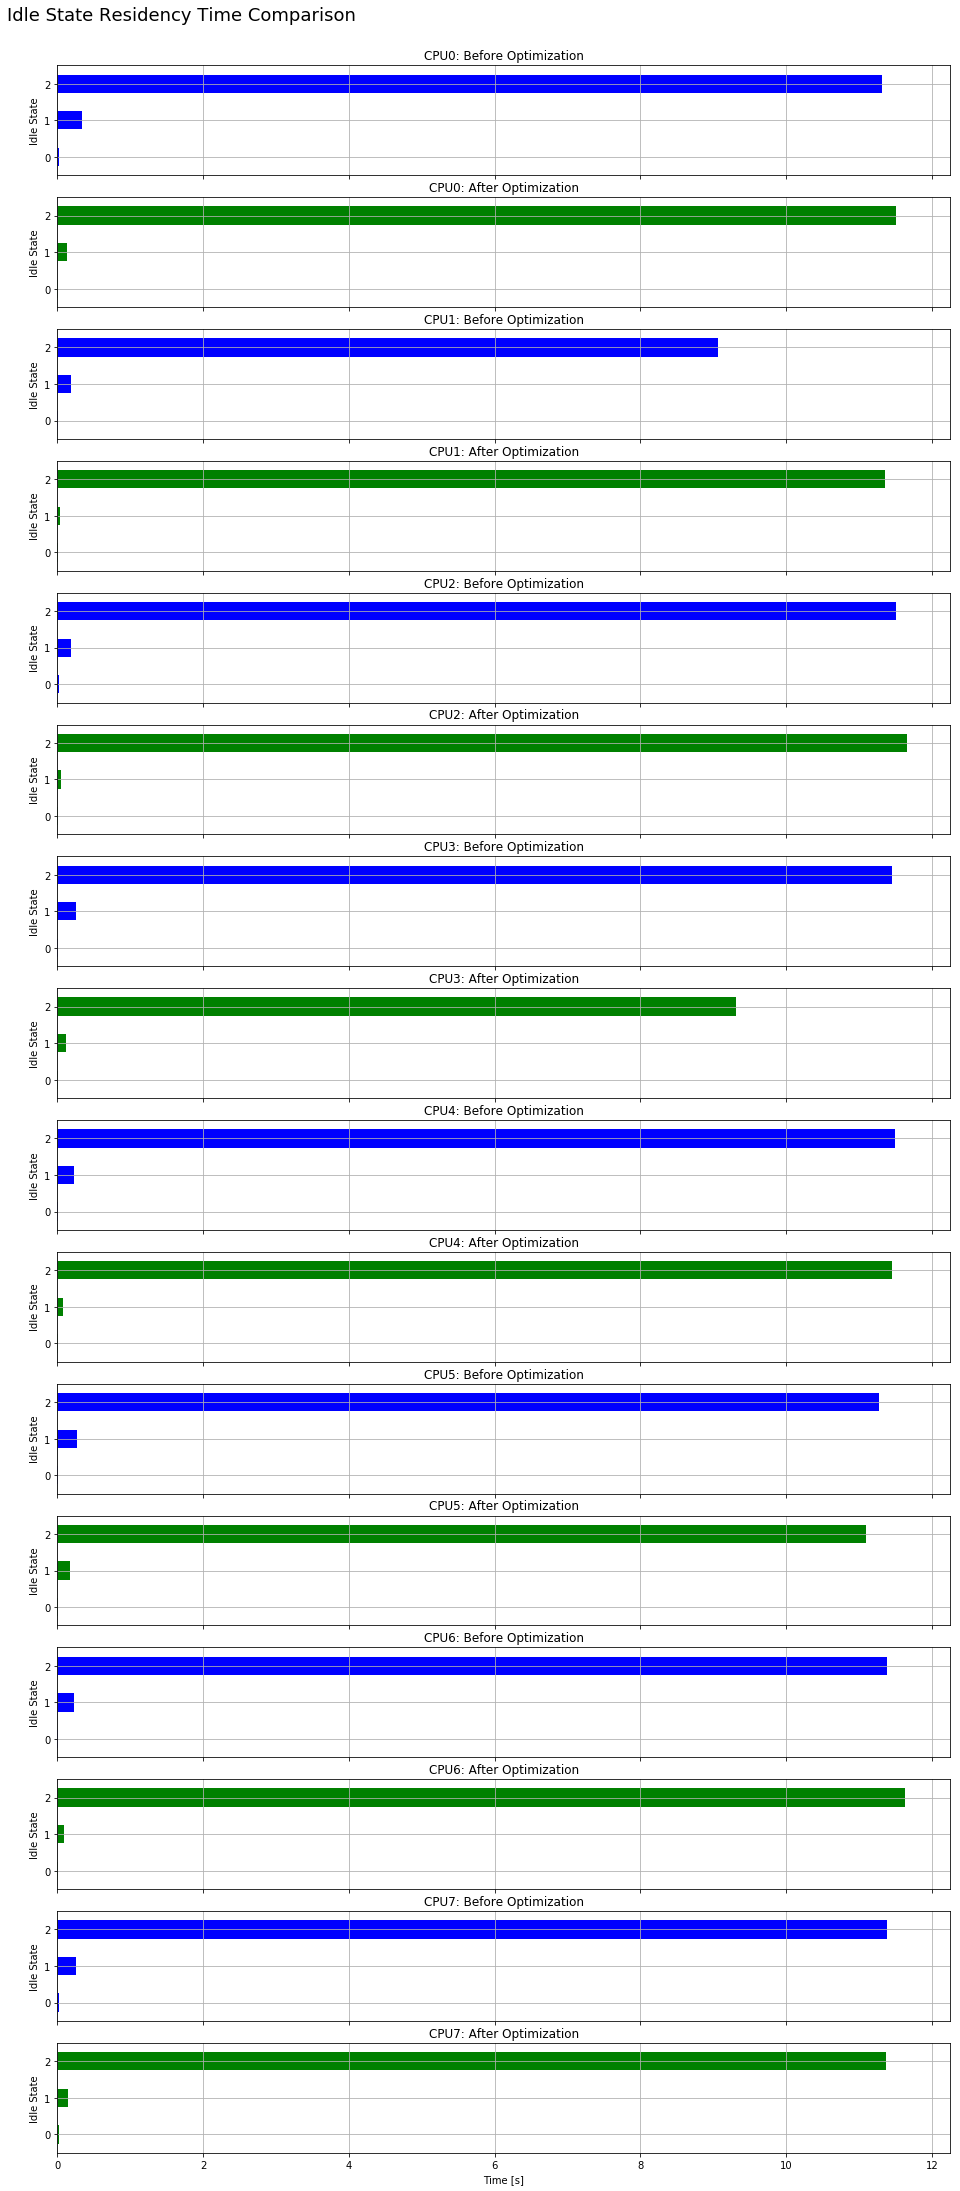

In [51]:
plotCPUIdleStateResidencyComparison(prev_ia, post_ia)

In [52]:
df = dfAllCPUIdleStateEstimationStatisticsDiff(prev_ia, post_ia, [ 1, 1000, 2700, 10000000000 ])
df

,cpu,good_est,over_est,under_est,cpu,good_est,over_est,under_est,cpu,good_est,over_est,under_est
0,0,35,0,7,0,26,0,3,0,-9,0,-4
1,0,13,24,80,0,10,18,30,0,-3,-6,-50
2,0,299,76,0,0,322,79,0,0,23,3,0
0,1,16,0,8,1,10,0,4,0,-6,0,-4
1,1,9,9,46,1,10,0,5,0,1,-9,-41
2,1,1051,24,0,1,93,28,0,0,-958,4,0
0,2,11,0,8,2,13,0,3,0,2,0,-5
1,2,10,12,42,2,12,4,7,0,2,-8,-35
2,2,94,22,0,2,96,30,0,0,2,8,0
0,3,9,0,6,3,11,0,1,0,2,0,-5


# Test case6: Period: 10ms, dutycycle: 30%

In [53]:
res_dir = '/home/leoy/Work2/Develop/tools/lisa/results/cpuidle_prev_opt/example_10ms_30pct'
trace_file = os.path.join(res_dir, "trace.dat")
prev_trace = Trace(hikey620_platform, trace_file, events=hikey620_conf['ftrace']['events'], normalize_time=True)
prev_ia = prev_trace.analysis.idle

res_dir = '/home/leoy/Work2/Develop/tools/lisa/results/cpuidle_post_opt/example_10ms_30pct'
trace_file = os.path.join(res_dir, "trace.dat")
post_trace = Trace(hikey620_platform, trace_file, events=hikey620_conf['ftrace']['events'], normalize_time=True)
post_ia = post_trace.analysis.idle

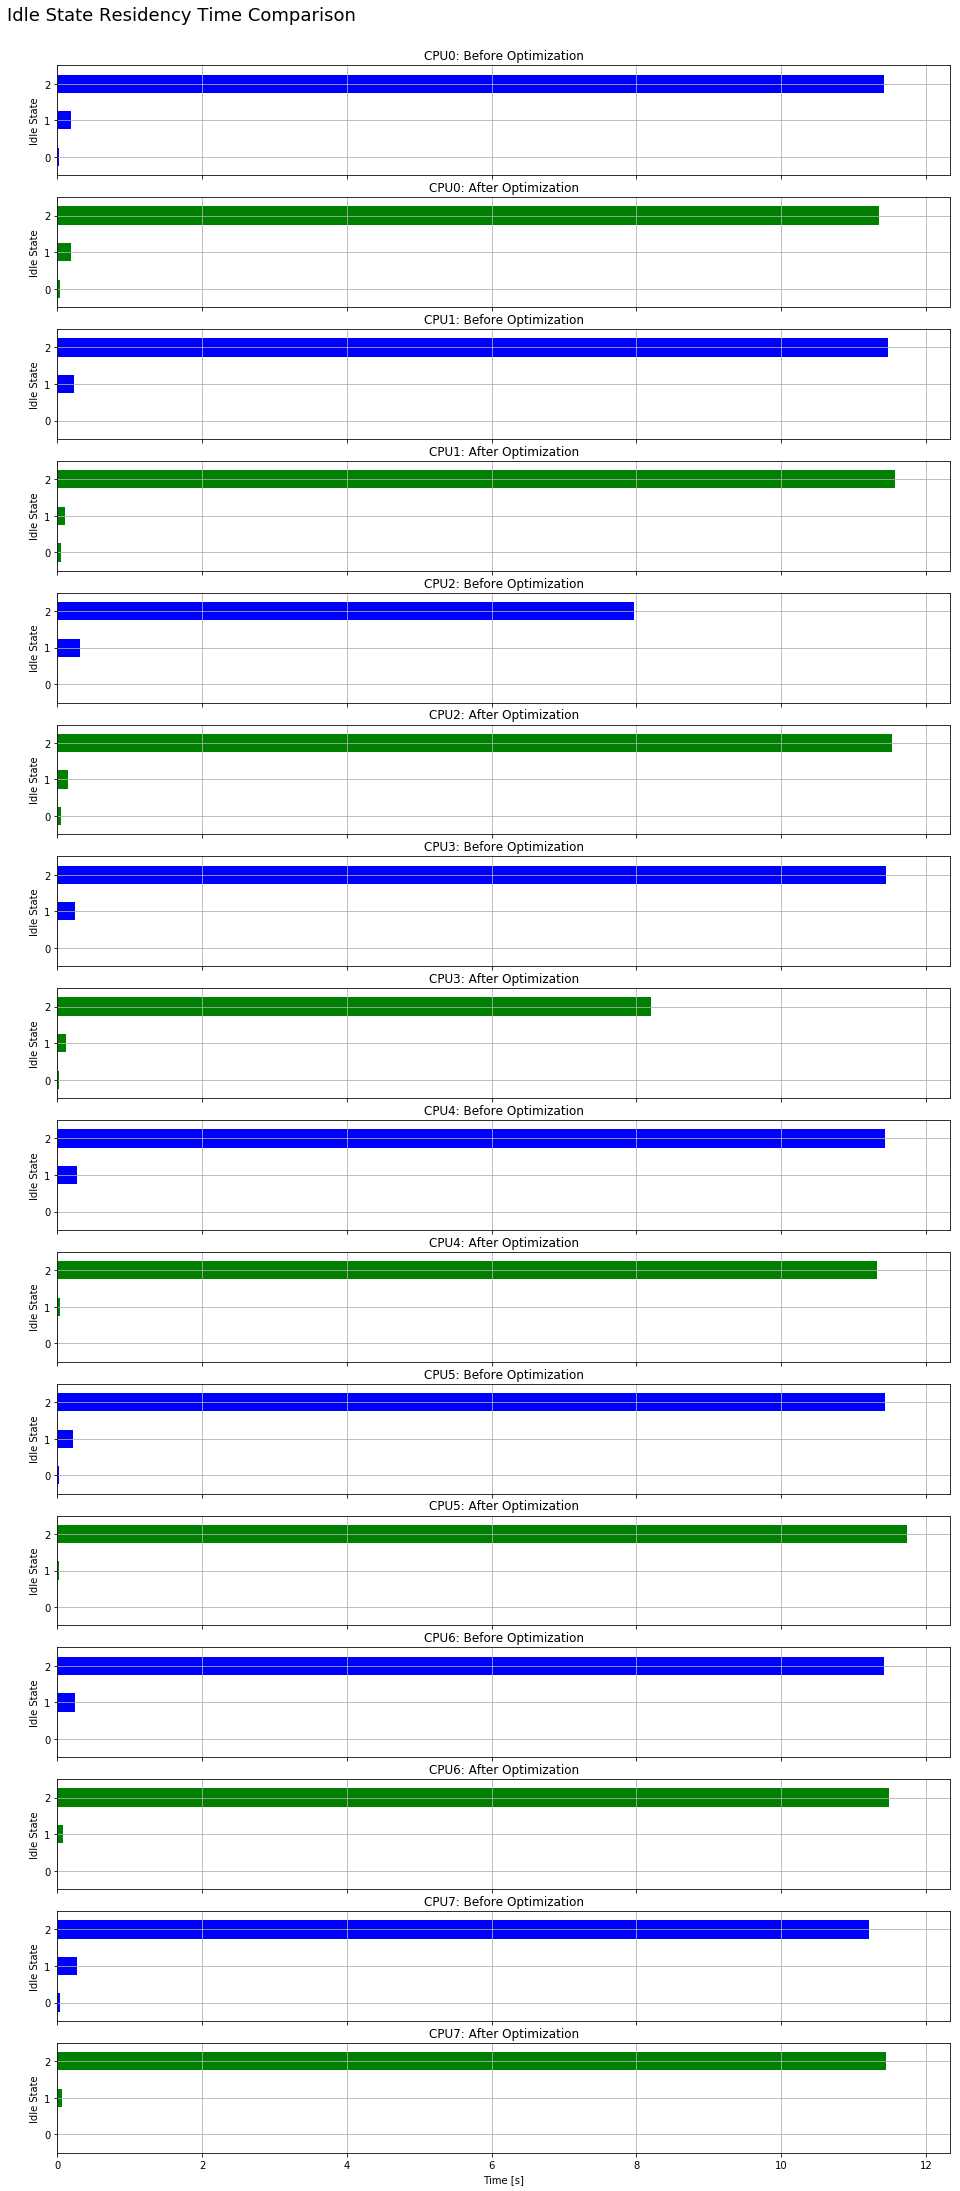

In [54]:
plotCPUIdleStateResidencyComparison(prev_ia, post_ia)

In [55]:
df = dfAllCPUIdleStateEstimationStatisticsDiff(prev_ia, post_ia, [ 1, 1000, 2700, 10000000000 ])
df

,cpu,good_est,over_est,under_est,cpu,good_est,over_est,under_est,cpu,good_est,over_est,under_est
0,0,22,0,10,0,165,0,10,0,143,0,0
1,0,13,8,41,0,19,43,38,0,6,35,-3
2,0,312,199,0,0,321,151,0,0,9,-48,0
0,1,8,0,5,1,96,0,13,0,88,0,8
1,1,8,2,58,1,10,20,21,0,2,18,-37
2,1,75,22,0,1,74,24,0,0,-1,2,0
0,2,25,0,3,2,137,0,18,0,112,0,15
1,2,32,8,65,2,13,30,30,0,-19,22,-35
2,2,1047,20,0,2,77,40,0,0,-970,20,0
0,3,9,0,4,3,30,0,3,0,21,0,-1


# Test case7: Period: 10ms, dutycycle: 40%

In [56]:
res_dir = '/home/leoy/Work2/Develop/tools/lisa/results/cpuidle_prev_opt/example_10ms_40pct'
trace_file = os.path.join(res_dir, "trace.dat")
prev_trace = Trace(hikey620_platform, trace_file, events=hikey620_conf['ftrace']['events'], normalize_time=True)
prev_ia = prev_trace.analysis.idle

res_dir = '/home/leoy/Work2/Develop/tools/lisa/results/cpuidle_post_opt/example_10ms_40pct'
trace_file = os.path.join(res_dir, "trace.dat")
post_trace = Trace(hikey620_platform, trace_file, events=hikey620_conf['ftrace']['events'], normalize_time=True)
post_ia = post_trace.analysis.idle

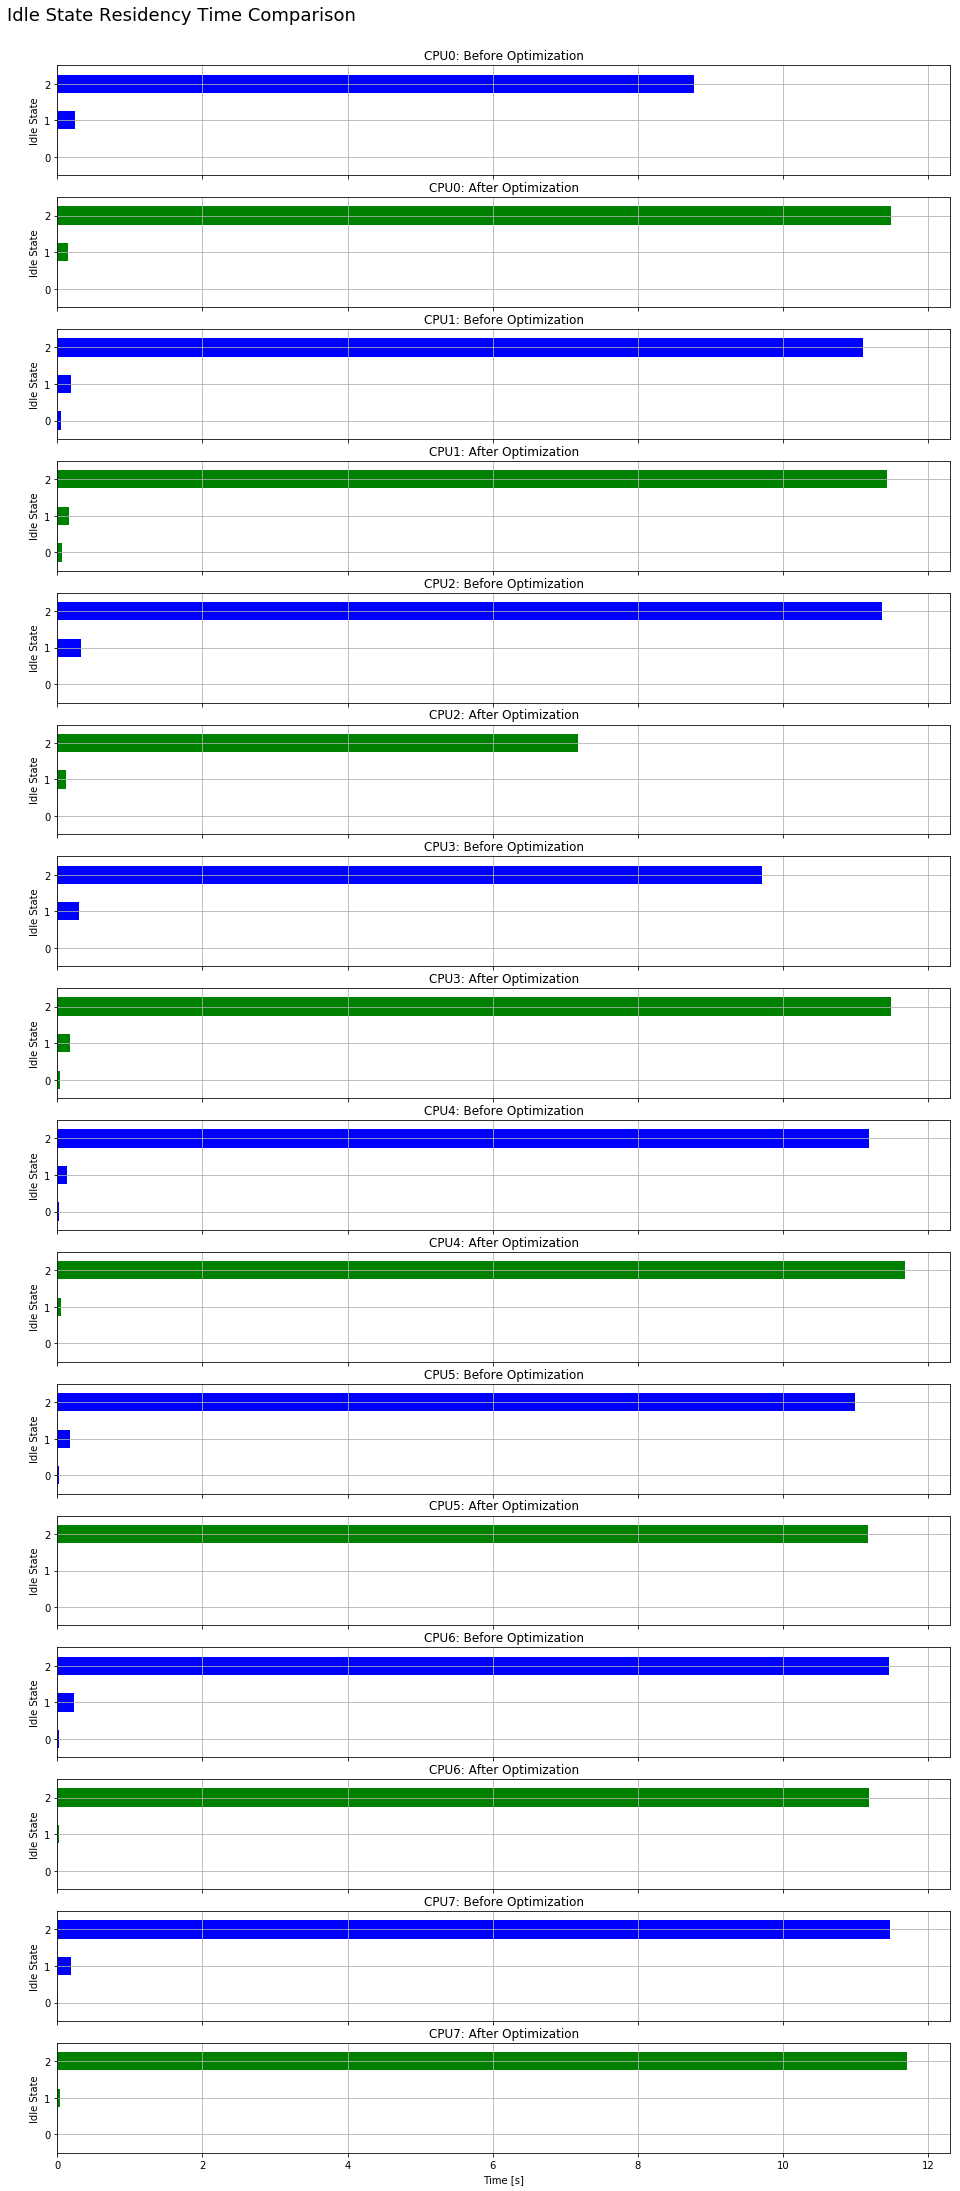

In [57]:
plotCPUIdleStateResidencyComparison(prev_ia, post_ia)

In [58]:
df = dfAllCPUIdleStateEstimationStatisticsDiff(prev_ia, post_ia, [ 1, 1000, 2700, 10000000000 ])
df

,cpu,good_est,over_est,under_est,cpu,good_est,over_est,under_est,cpu,good_est,over_est,under_est
0,0,96,0,2,0,25,0,5,0,-71,0,3
1,0,29,6,48,0,18,25,27,0,-11,19,-21
2,0,770,142,0,0,311,82,0,0,-459,-60,0
0,1,75,0,15,1,30,0,17,0,-45,0,2
1,1,13,9,43,1,16,21,34,0,3,12,-9
2,1,196,11,0,1,73,36,0,0,-123,25,0
0,2,24,0,5,2,13,0,2,0,-11,0,-3
1,2,14,14,76,2,17,13,23,0,3,-1,-53
2,2,132,36,0,2,1083,30,0,0,951,-6,0
0,3,13,0,3,3,29,0,11,0,16,0,8


# Test case8: Period: 5ms, dutycycle: 1%

In [59]:
res_dir = '/home/leoy/Work2/Develop/tools/lisa/results/cpuidle_prev_opt/example_5ms_1pct'
trace_file = os.path.join(res_dir, "trace.dat")
prev_trace = Trace(hikey620_platform, trace_file, events=hikey620_conf['ftrace']['events'], normalize_time=True)
prev_ia = prev_trace.analysis.idle

res_dir = '/home/leoy/Work2/Develop/tools/lisa/results/cpuidle_post_opt/example_5ms_1pct'
trace_file = os.path.join(res_dir, "trace.dat")
post_trace = Trace(hikey620_platform, trace_file, events=hikey620_conf['ftrace']['events'], normalize_time=True)
post_ia = post_trace.analysis.idle

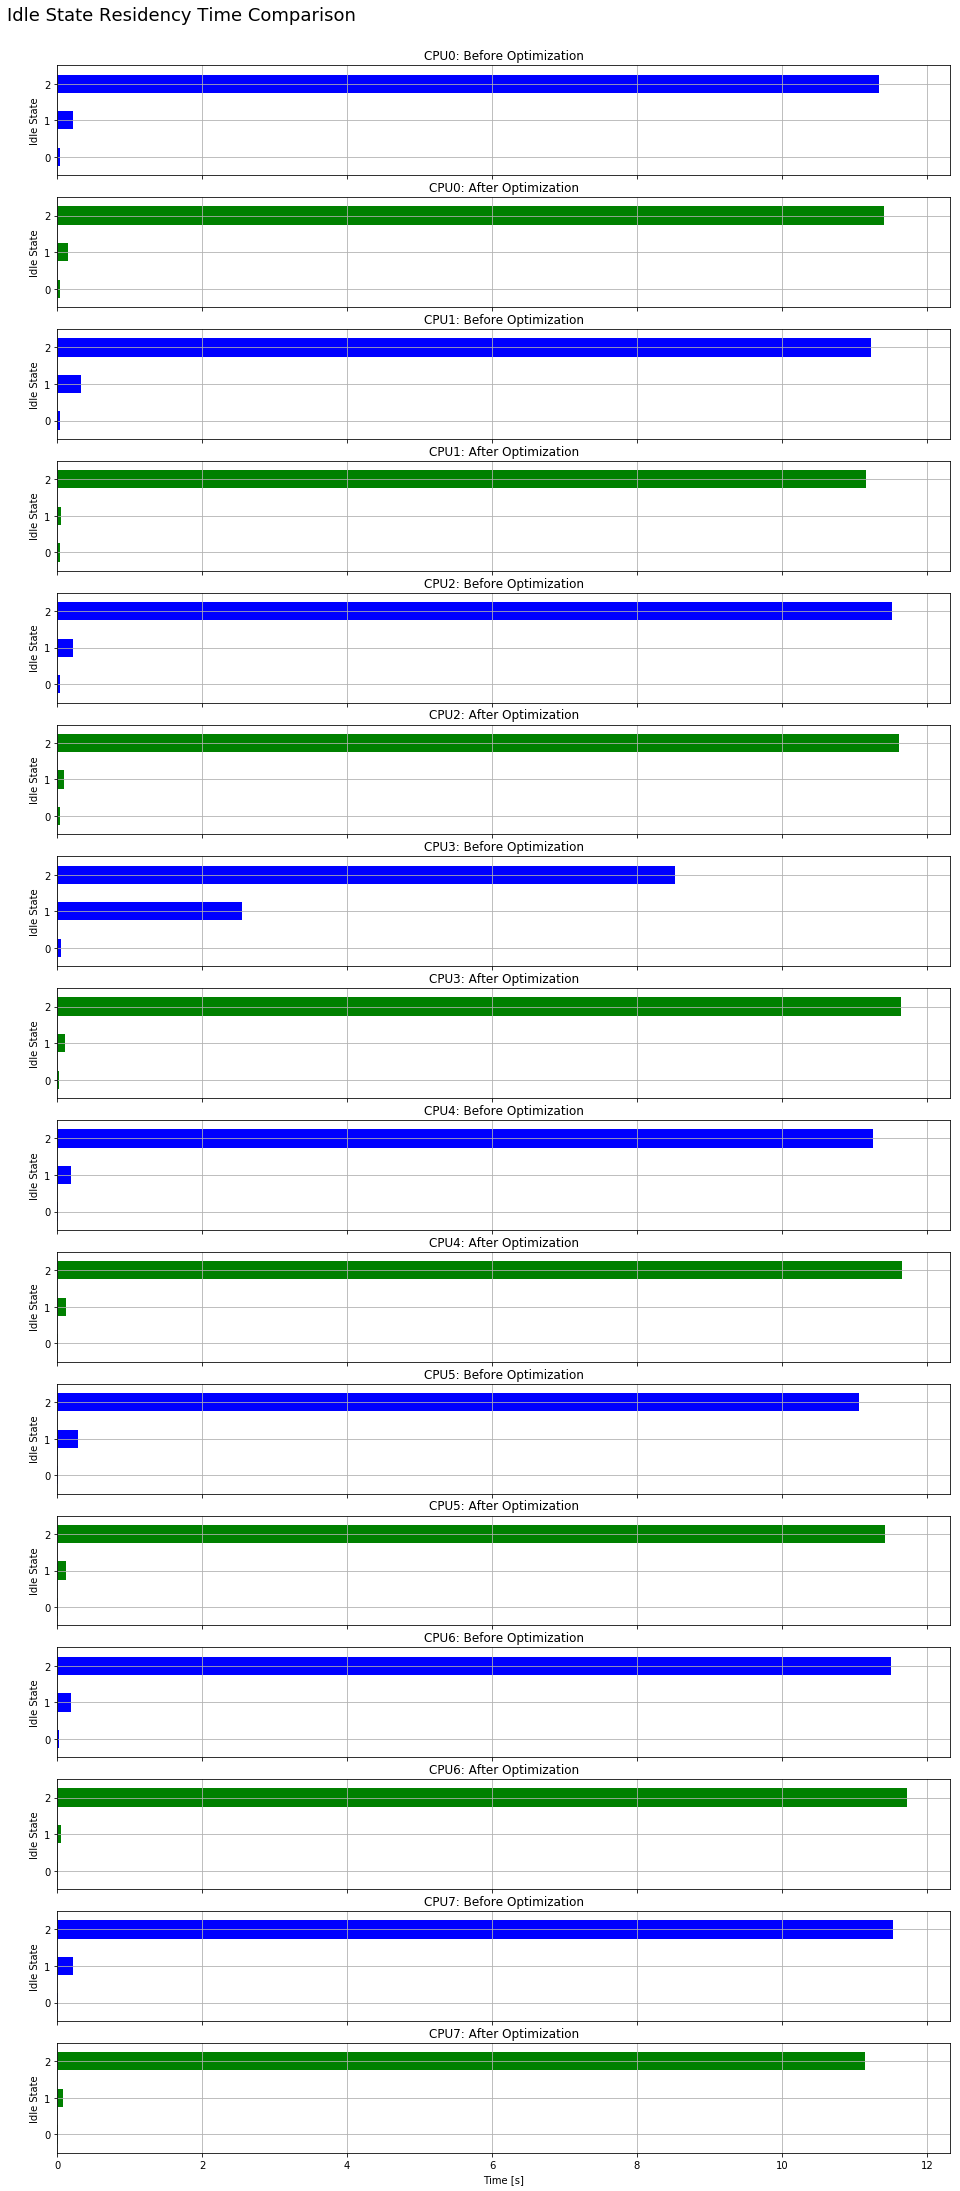

In [60]:
plotCPUIdleStateResidencyComparison(prev_ia, post_ia)

In [61]:
df = dfAllCPUIdleStateEstimationStatisticsDiff(prev_ia, post_ia, [ 1, 1000, 2700, 10000000000 ])
df

,cpu,good_est,over_est,under_est,cpu,good_est,over_est,under_est,cpu,good_est,over_est,under_est
0,0,198,0,15,0,721,0,8,0,523,0,-7
1,0,12,40,48,0,8,55,34,0,-4,15,-14
2,0,73,207,0,0,413,135,0,0,340,-72,0
0,1,32,0,15,1,565,0,6,0,533,0,-9
1,1,13,26,77,1,12,19,7,0,-1,-7,-70
2,1,56,41,0,1,1747,84,0,0,1691,43,0
0,2,35,0,11,2,44,0,13,0,9,0,2
1,2,10,14,47,2,14,11,19,0,4,-3,-28
2,2,85,9,0,2,101,27,0,0,16,18,0
0,3,894,0,8,3,20,0,8,0,-874,0,0


# Test case9: Period: 5ms, dutycycle: 3%

In [62]:
res_dir = '/home/leoy/Work2/Develop/tools/lisa/results/cpuidle_prev_opt/example_5ms_3pct'
trace_file = os.path.join(res_dir, "trace.dat")
prev_trace = Trace(hikey620_platform, trace_file, events=hikey620_conf['ftrace']['events'], normalize_time=True)
prev_ia = prev_trace.analysis.idle

res_dir = '/home/leoy/Work2/Develop/tools/lisa/results/cpuidle_post_opt/example_5ms_3pct'
trace_file = os.path.join(res_dir, "trace.dat")
post_trace = Trace(hikey620_platform, trace_file, events=hikey620_conf['ftrace']['events'], normalize_time=True)
post_ia = post_trace.analysis.idle

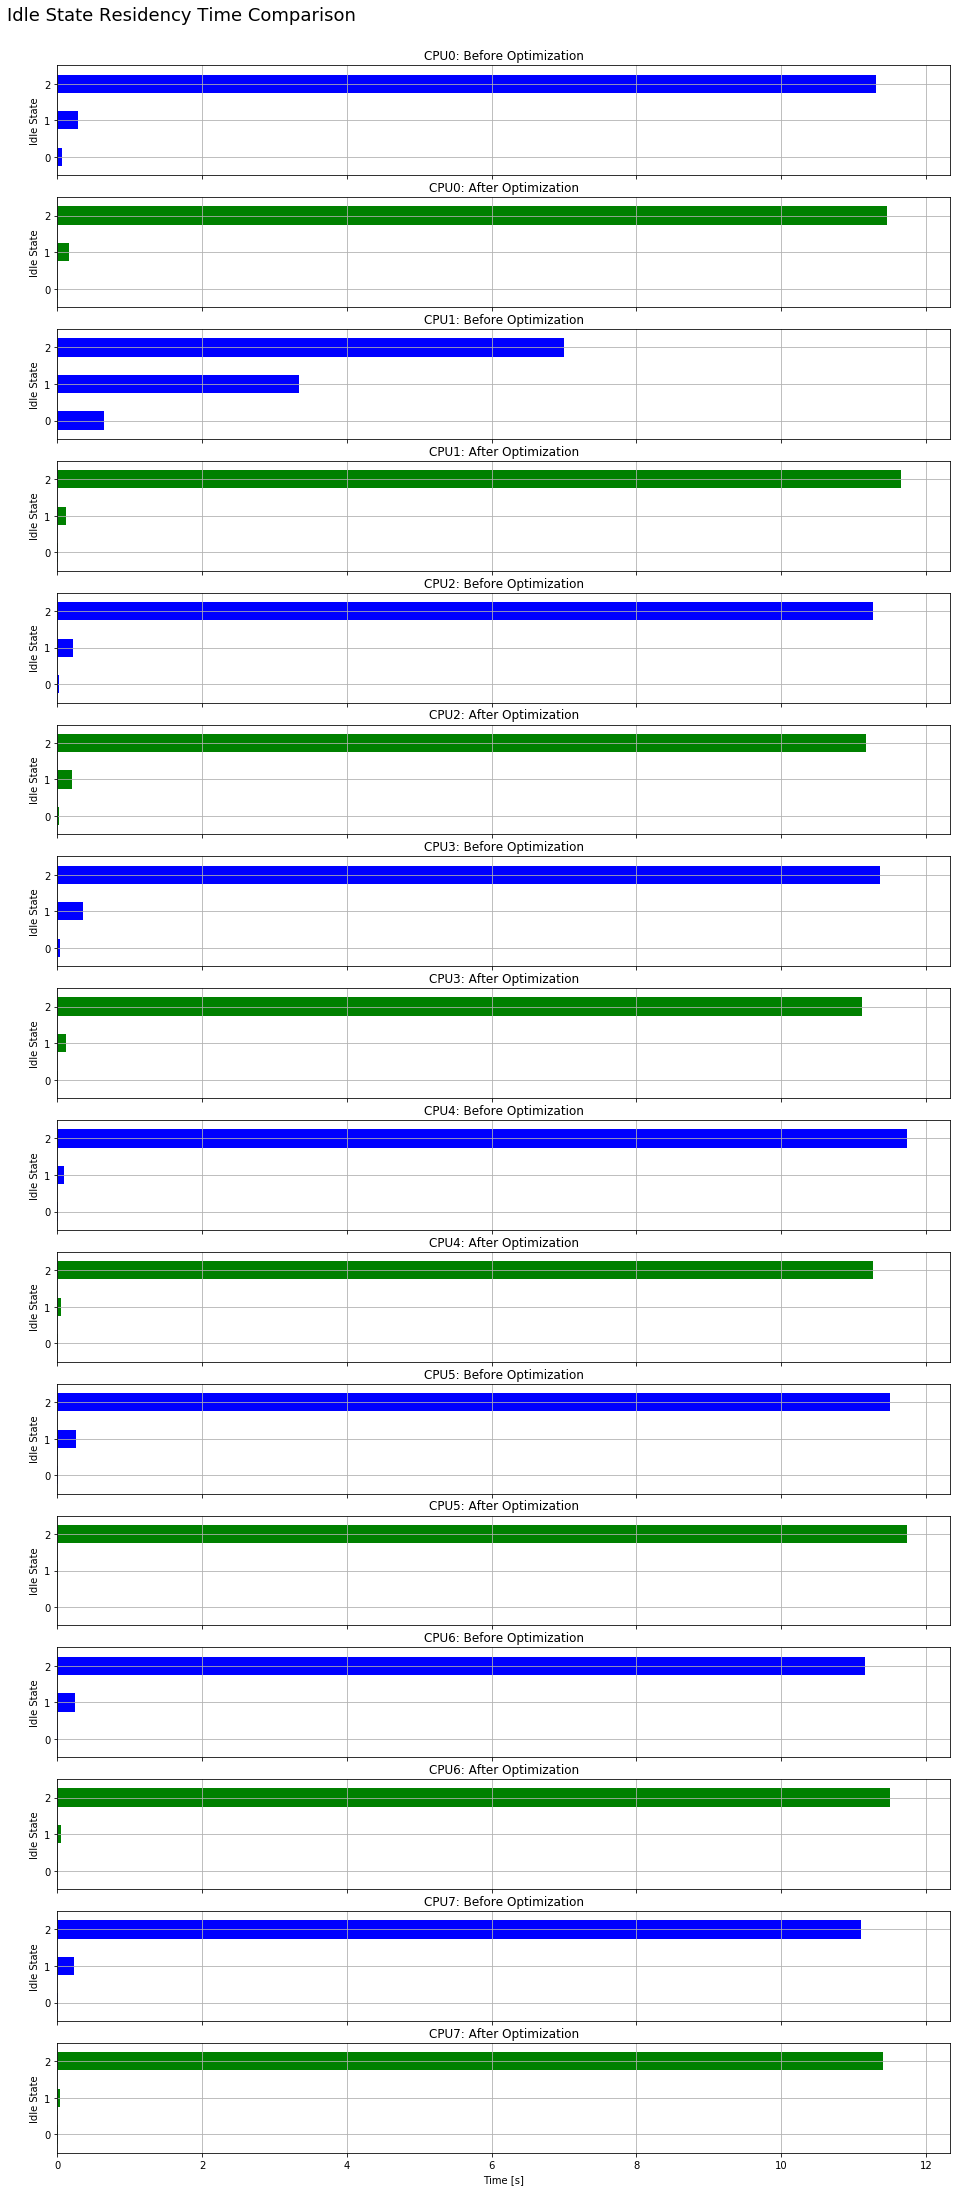

In [63]:
plotCPUIdleStateResidencyComparison(prev_ia, post_ia)

In [64]:
df = dfAllCPUIdleStateEstimationStatisticsDiff(prev_ia, post_ia, [ 1, 1000, 2700, 10000000000 ])
df

,cpu,good_est,over_est,under_est,cpu,good_est,over_est,under_est,cpu,good_est,over_est,under_est
0,0,258,0,16,0,44,0,4,0,-214,0,-12
1,0,11,54,68,0,15,39,33,0,4,-15,-35
2,0,95,151,0,0,104,78,0,0,9,-73,0
0,1,1037,0,10,1,25,0,5,0,-1012,0,-5
1,1,963,29,583,1,7,25,25,0,-956,-4,-558
2,1,1532,4,0,1,86,31,0,0,-1446,27,0
0,2,40,0,9,2,32,0,9,0,-8,0,0
1,2,15,14,49,2,29,27,38,0,14,13,-11
2,2,113,22,0,2,877,60,0,0,764,38,0
0,3,32,0,11,3,25,0,3,0,-7,0,-8


# Test case9: Period: 5ms, dutycycle: 5%

In [65]:
res_dir = '/home/leoy/Work2/Develop/tools/lisa/results/cpuidle_prev_opt/example_5ms_5pct'
trace_file = os.path.join(res_dir, "trace.dat")
prev_trace = Trace(hikey620_platform, trace_file, events=hikey620_conf['ftrace']['events'], normalize_time=True)
prev_ia = prev_trace.analysis.idle

res_dir = '/home/leoy/Work2/Develop/tools/lisa/results/cpuidle_post_opt/example_5ms_5pct'
trace_file = os.path.join(res_dir, "trace.dat")
post_trace = Trace(hikey620_platform, trace_file, events=hikey620_conf['ftrace']['events'], normalize_time=True)
post_ia = post_trace.analysis.idle

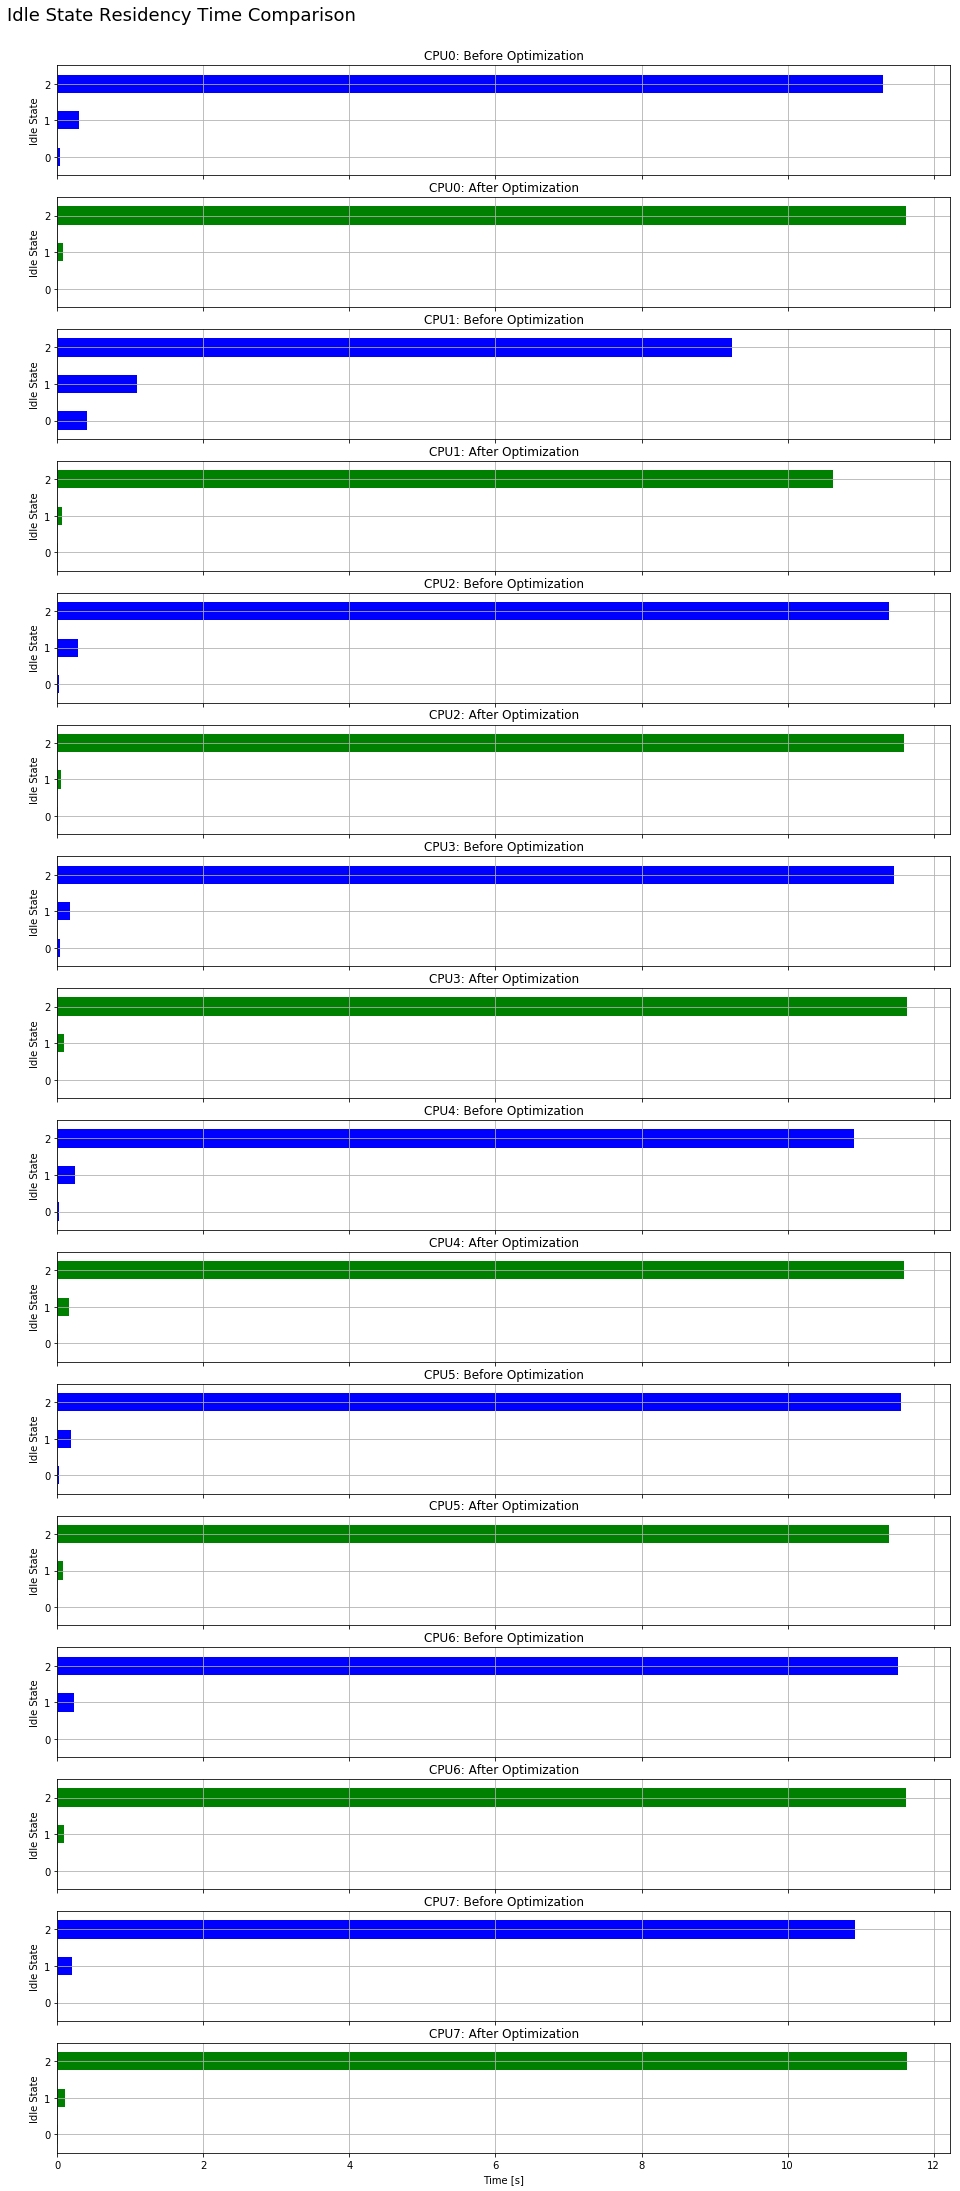

In [66]:
plotCPUIdleStateResidencyComparison(prev_ia, post_ia)

In [67]:
df = dfAllCPUIdleStateEstimationStatisticsDiff(prev_ia, post_ia, [ 1, 1000, 2700, 10000000000 ])
df

,cpu,good_est,over_est,under_est,cpu,good_est,over_est,under_est,cpu,good_est,over_est,under_est
0,0,169,0,3,0,24,0,4,0,-145,0,1
1,0,58,40,56,0,11,17,15,0,-47,-23,-41
2,0,200,99,0,0,137,82,0,0,-63,-17,0
0,1,937,0,6,1,12,0,3,0,-925,0,-3
1,1,528,0,117,1,14,5,10,0,-514,5,-107
2,1,1843,13,0,1,2100,47,0,0,257,34,0
0,2,28,0,6,2,15,0,3,0,-13,0,-3
1,2,15,13,68,2,9,3,11,0,-6,-10,-57
2,2,89,15,0,2,70,21,0,0,-19,6,0
0,3,15,0,11,3,17,0,5,0,2,0,-6


# Test case9: Period: 5ms, dutycycle: 10%

In [68]:
res_dir = '/home/leoy/Work2/Develop/tools/lisa/results/cpuidle_prev_opt/example_5ms_10pct'
trace_file = os.path.join(res_dir, "trace.dat")
prev_trace = Trace(hikey620_platform, trace_file, events=hikey620_conf['ftrace']['events'], normalize_time=True)
prev_ia = prev_trace.analysis.idle

res_dir = '/home/leoy/Work2/Develop/tools/lisa/results/cpuidle_post_opt/example_5ms_10pct'
trace_file = os.path.join(res_dir, "trace.dat")
post_trace = Trace(hikey620_platform, trace_file, events=hikey620_conf['ftrace']['events'], normalize_time=True)
post_ia = post_trace.analysis.idle

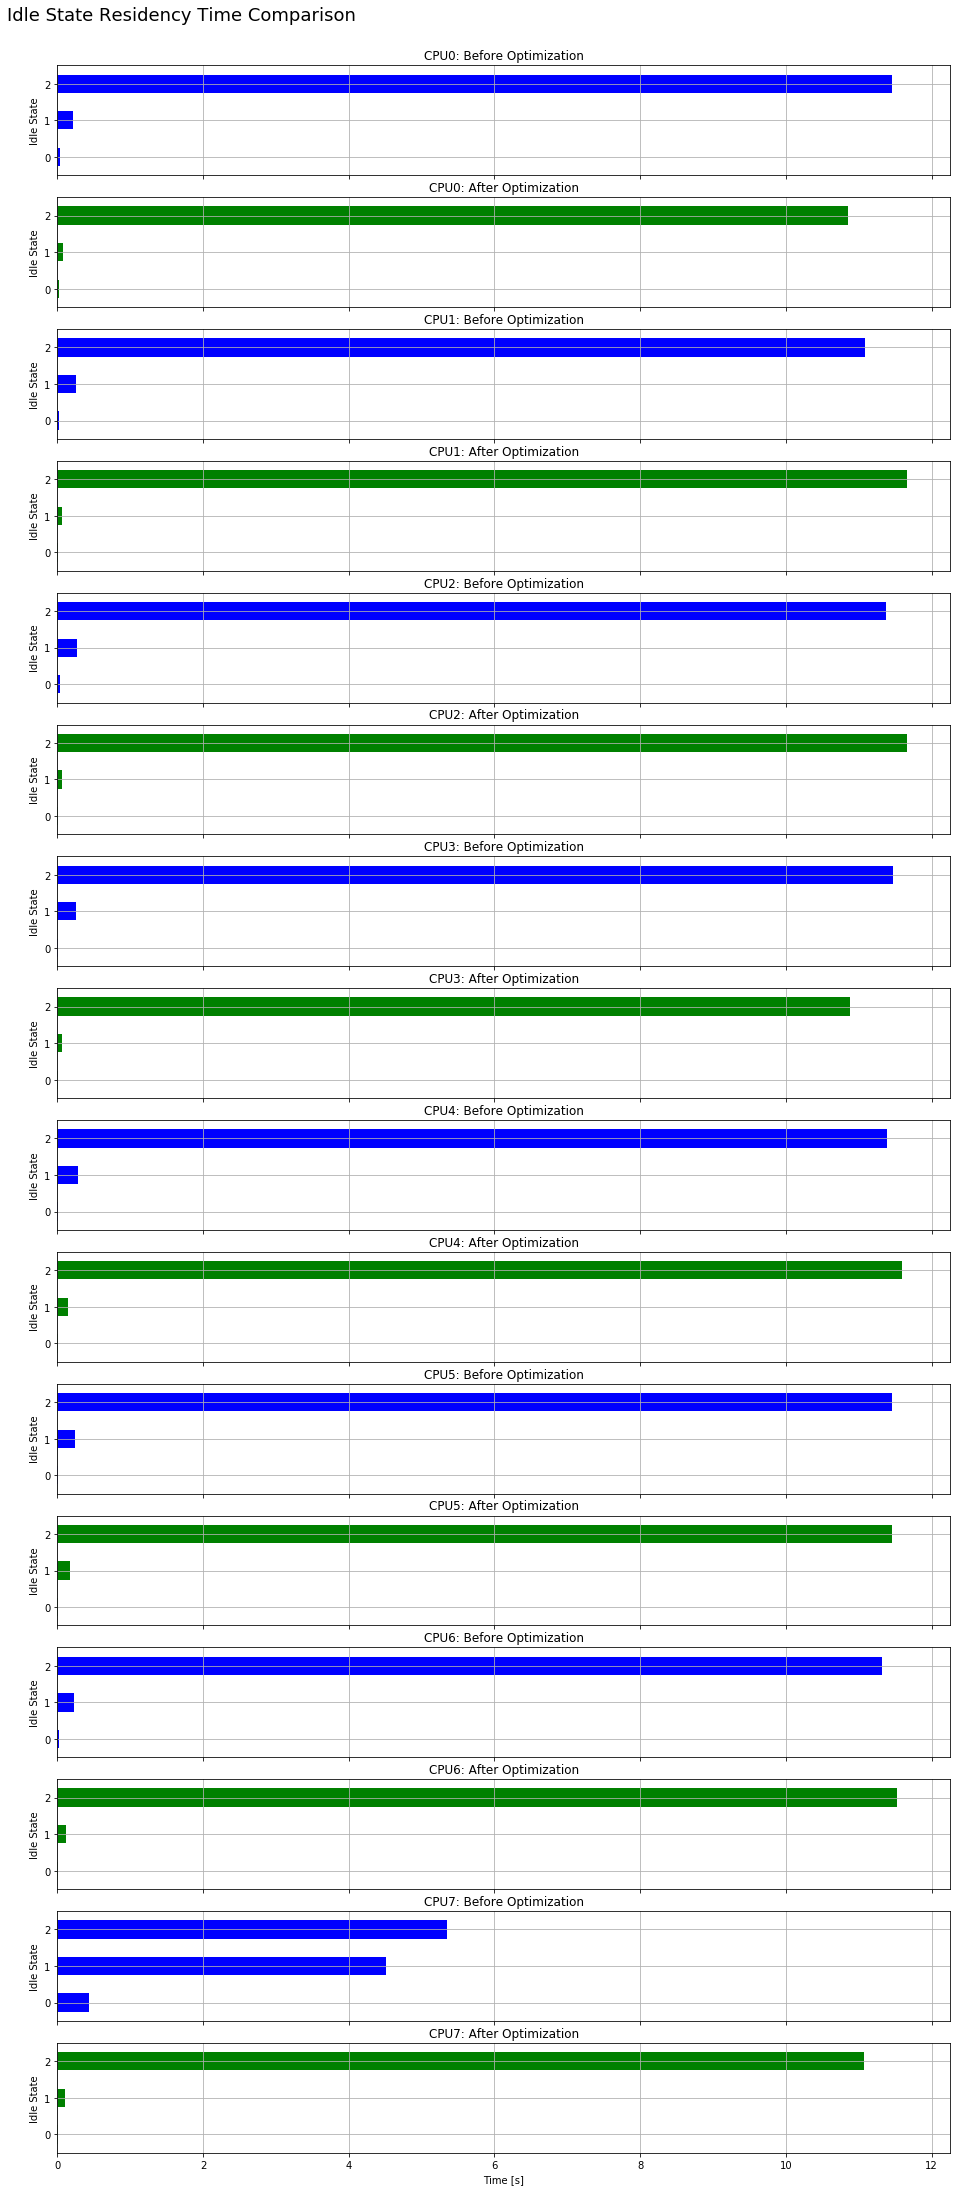

In [69]:
plotCPUIdleStateResidencyComparison(prev_ia, post_ia)

In [70]:
df = dfAllCPUIdleStateEstimationStatisticsDiff(prev_ia, post_ia, [ 1, 1000, 2700, 10000000000 ])
df

,cpu,good_est,over_est,under_est,cpu,good_est,over_est,under_est,cpu,good_est,over_est,under_est
0,0,263,0,11,0,36,0,4,0,-227,0,-7
1,0,11,18,48,0,23,15,9,0,12,-3,-39
2,0,86,132,0,0,1130,106,0,0,1044,-26,0
0,1,36,0,8,1,6,0,3,0,-30,0,-5
1,1,10,24,61,1,8,9,11,0,-2,-15,-50
2,1,46,19,0,1,137,29,0,0,91,10,0
0,2,37,0,11,2,13,0,4,0,-24,0,-7
1,2,7,23,66,2,7,6,12,0,0,-17,-54
2,2,101,15,0,2,97,14,0,0,-4,-1,0
0,3,13,0,1,3,11,0,1,0,-2,0,0


# Test case9: Period: 5ms, dutycycle: 20%

In [71]:
res_dir = '/home/leoy/Work2/Develop/tools/lisa/results/cpuidle_prev_opt/example_5ms_20pct'
trace_file = os.path.join(res_dir, "trace.dat")
prev_trace = Trace(hikey620_platform, trace_file, events=hikey620_conf['ftrace']['events'], normalize_time=True)
prev_ia = prev_trace.analysis.idle

res_dir = '/home/leoy/Work2/Develop/tools/lisa/results/cpuidle_post_opt/example_5ms_20pct'
trace_file = os.path.join(res_dir, "trace.dat")
post_trace = Trace(hikey620_platform, trace_file, events=hikey620_conf['ftrace']['events'], normalize_time=True)
post_ia = post_trace.analysis.idle

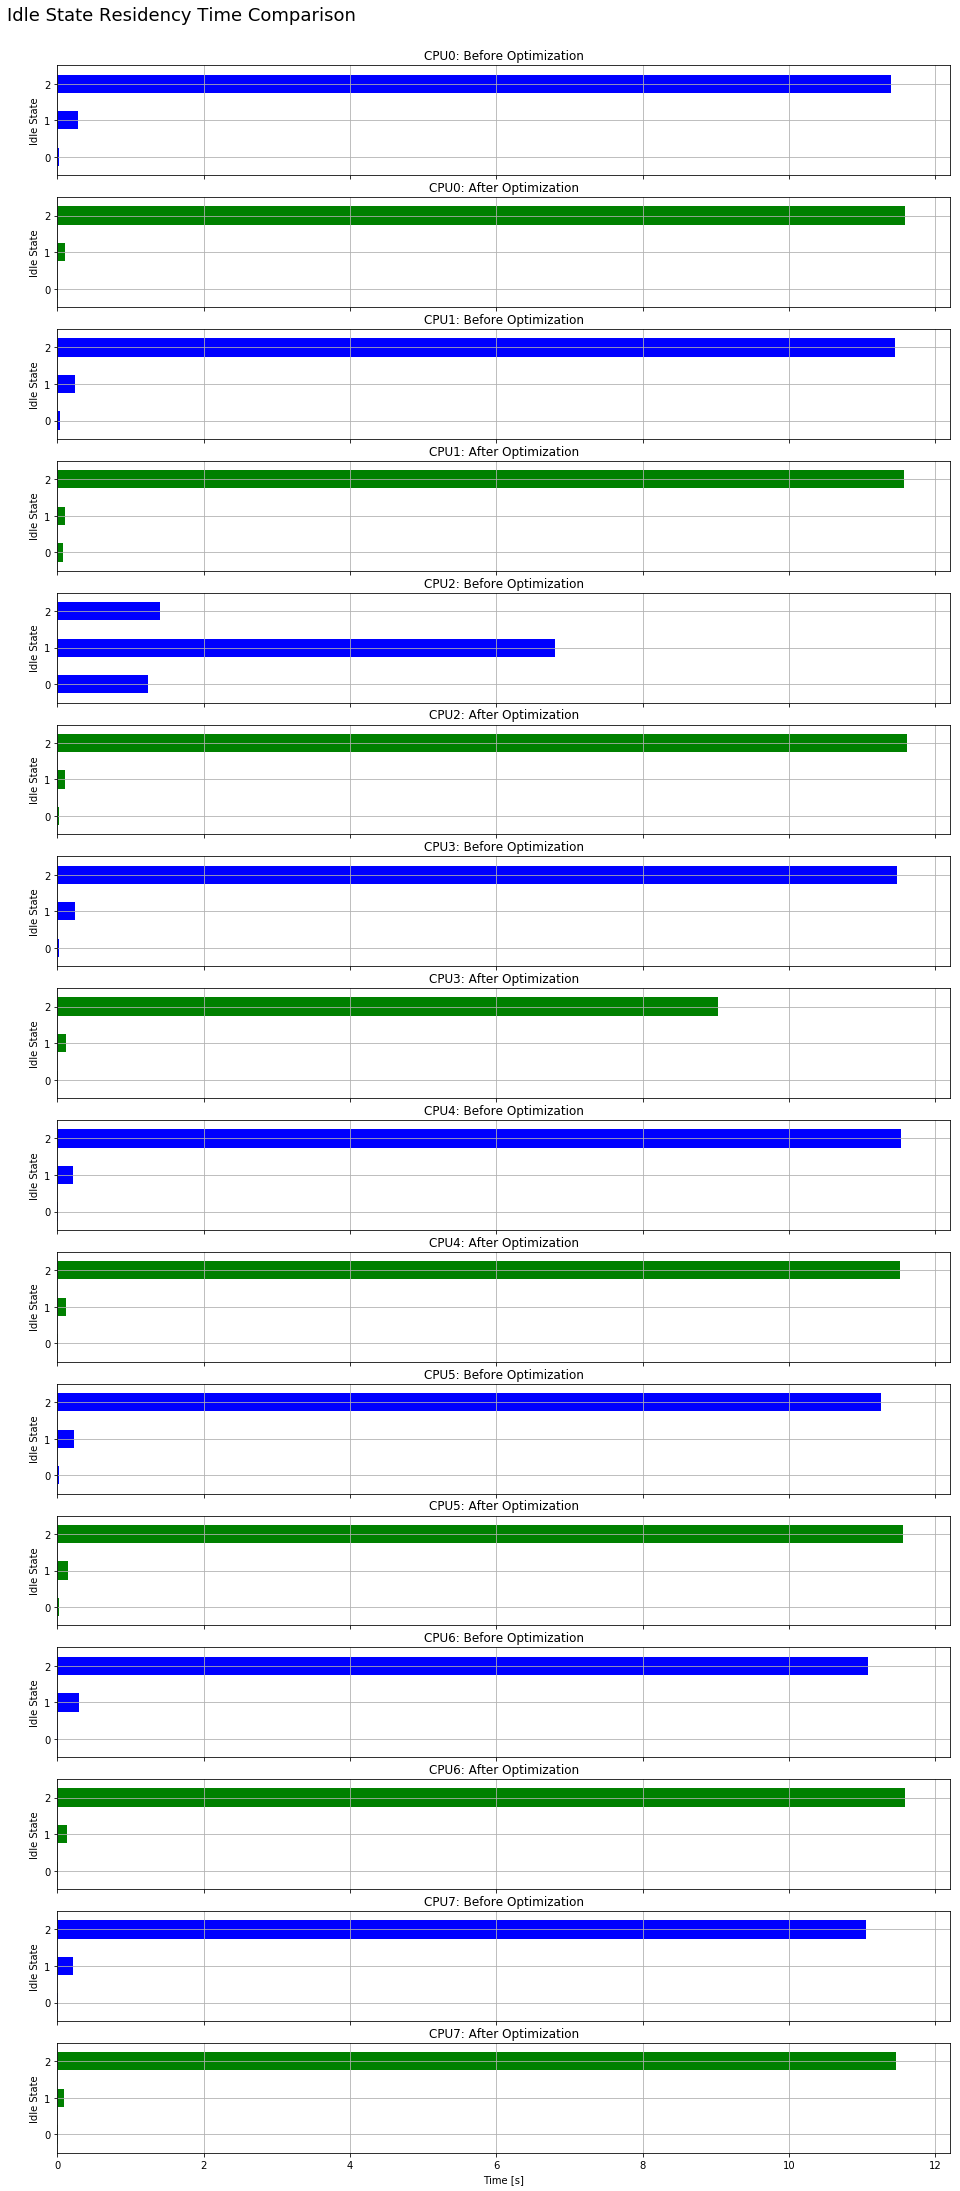

In [72]:
plotCPUIdleStateResidencyComparison(prev_ia, post_ia)

In [73]:
df = dfAllCPUIdleStateEstimationStatisticsDiff(prev_ia, post_ia, [ 1, 1000, 2700, 10000000000 ])
df

,cpu,good_est,over_est,under_est,cpu,good_est,over_est,under_est,cpu,good_est,over_est,under_est
0,0,49,0,9,0,43,0,3,0,-6,0,-6
1,0,11,27,64,0,7,41,21,0,-4,14,-43
2,0,95,62,0,0,205,230,0,0,110,168,0
0,1,27,0,11,1,120,0,20,0,93,0,9
1,1,15,17,56,1,10,12,22,0,-5,-5,-34
2,1,44,36,0,1,82,39,0,0,38,3,0
0,2,552,0,496,2,21,0,3,0,-531,0,-493
1,2,999,15,1564,2,18,10,22,0,-981,-5,-1542
2,2,43,12,0,2,91,22,0,0,48,10,0
0,3,31,0,6,3,14,0,5,0,-17,0,-1


# Test case9: Period: 5ms, dutycycle: 30%

In [74]:
res_dir = '/home/leoy/Work2/Develop/tools/lisa/results/cpuidle_prev_opt/example_5ms_30pct'
trace_file = os.path.join(res_dir, "trace.dat")
prev_trace = Trace(hikey620_platform, trace_file, events=hikey620_conf['ftrace']['events'], normalize_time=True)
prev_ia = prev_trace.analysis.idle

res_dir = '/home/leoy/Work2/Develop/tools/lisa/results/cpuidle_post_opt/example_5ms_30pct'
trace_file = os.path.join(res_dir, "trace.dat")
post_trace = Trace(hikey620_platform, trace_file, events=hikey620_conf['ftrace']['events'], normalize_time=True)
post_ia = post_trace.analysis.idle

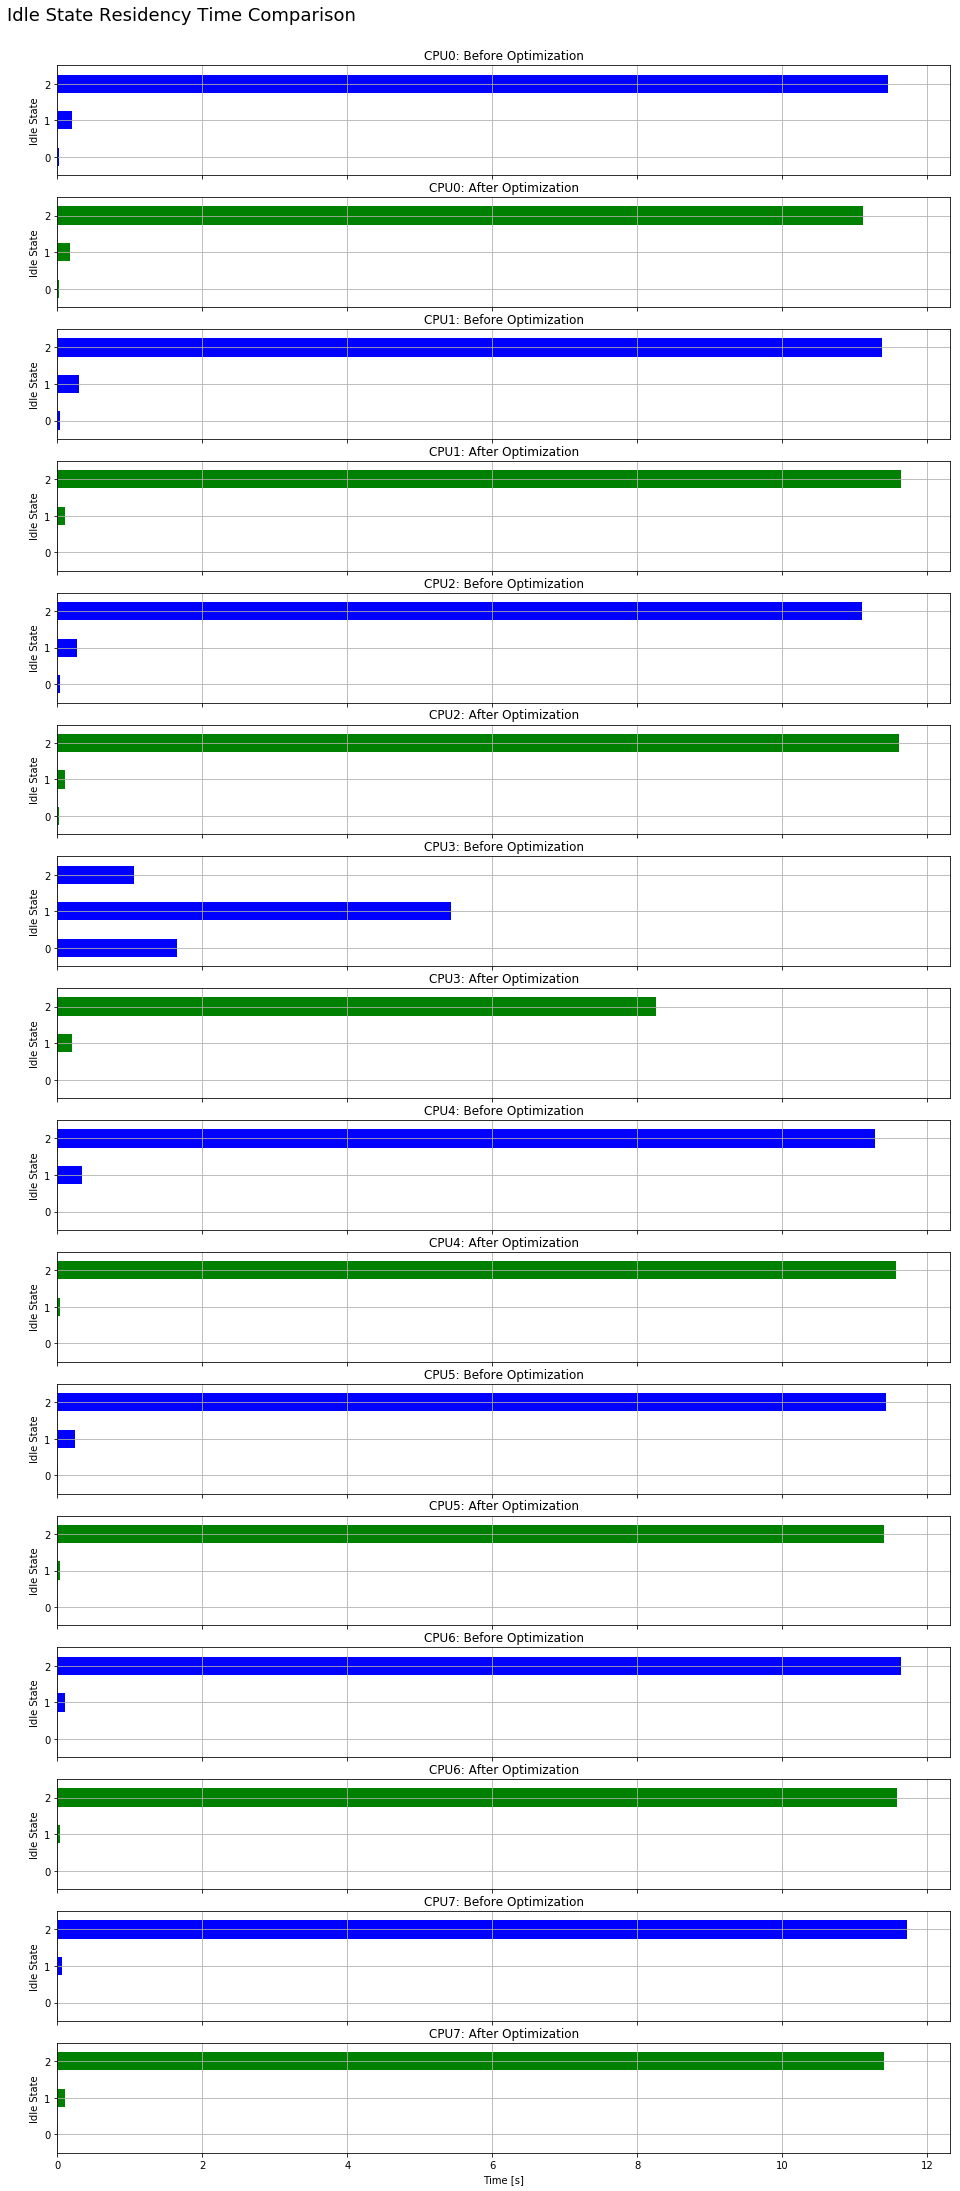

In [75]:
plotCPUIdleStateResidencyComparison(prev_ia, post_ia)

In [76]:
df = dfAllCPUIdleStateEstimationStatisticsDiff(prev_ia, post_ia, [ 1, 1000, 2700, 10000000000 ])
df

,cpu,good_est,over_est,under_est,cpu,good_est,over_est,under_est,cpu,good_est,over_est,under_est
0,0,99,0,7,0,42,0,7,0,-57,0,0
1,0,14,33,45,0,17,32,37,0,3,-1,-8
2,0,83,87,0,0,357,68,0,0,274,-19,0
0,1,30,0,12,1,22,0,6,0,-8,0,-6
1,1,13,26,71,1,13,12,20,0,0,-14,-51
2,1,65,24,0,1,59,26,0,0,-6,2,0
0,2,33,0,15,2,21,0,10,0,-12,0,-5
1,2,15,26,60,2,7,19,24,0,-8,-7,-36
2,2,75,23,0,2,84,31,0,0,9,8,0
0,3,1027,0,508,3,38,0,1,0,-989,0,-507


# Test case9: Period: 5ms, dutycycle: 40%

In [77]:
res_dir = '/home/leoy/Work2/Develop/tools/lisa/results/cpuidle_prev_opt/example_5ms_40pct'
trace_file = os.path.join(res_dir, "trace.dat")
prev_trace = Trace(hikey620_platform, trace_file, events=hikey620_conf['ftrace']['events'], normalize_time=True)
prev_ia = prev_trace.analysis.idle

res_dir = '/home/leoy/Work2/Develop/tools/lisa/results/cpuidle_post_opt/example_5ms_40pct'
trace_file = os.path.join(res_dir, "trace.dat")
post_trace = Trace(hikey620_platform, trace_file, events=hikey620_conf['ftrace']['events'], normalize_time=True)
post_ia = post_trace.analysis.idle

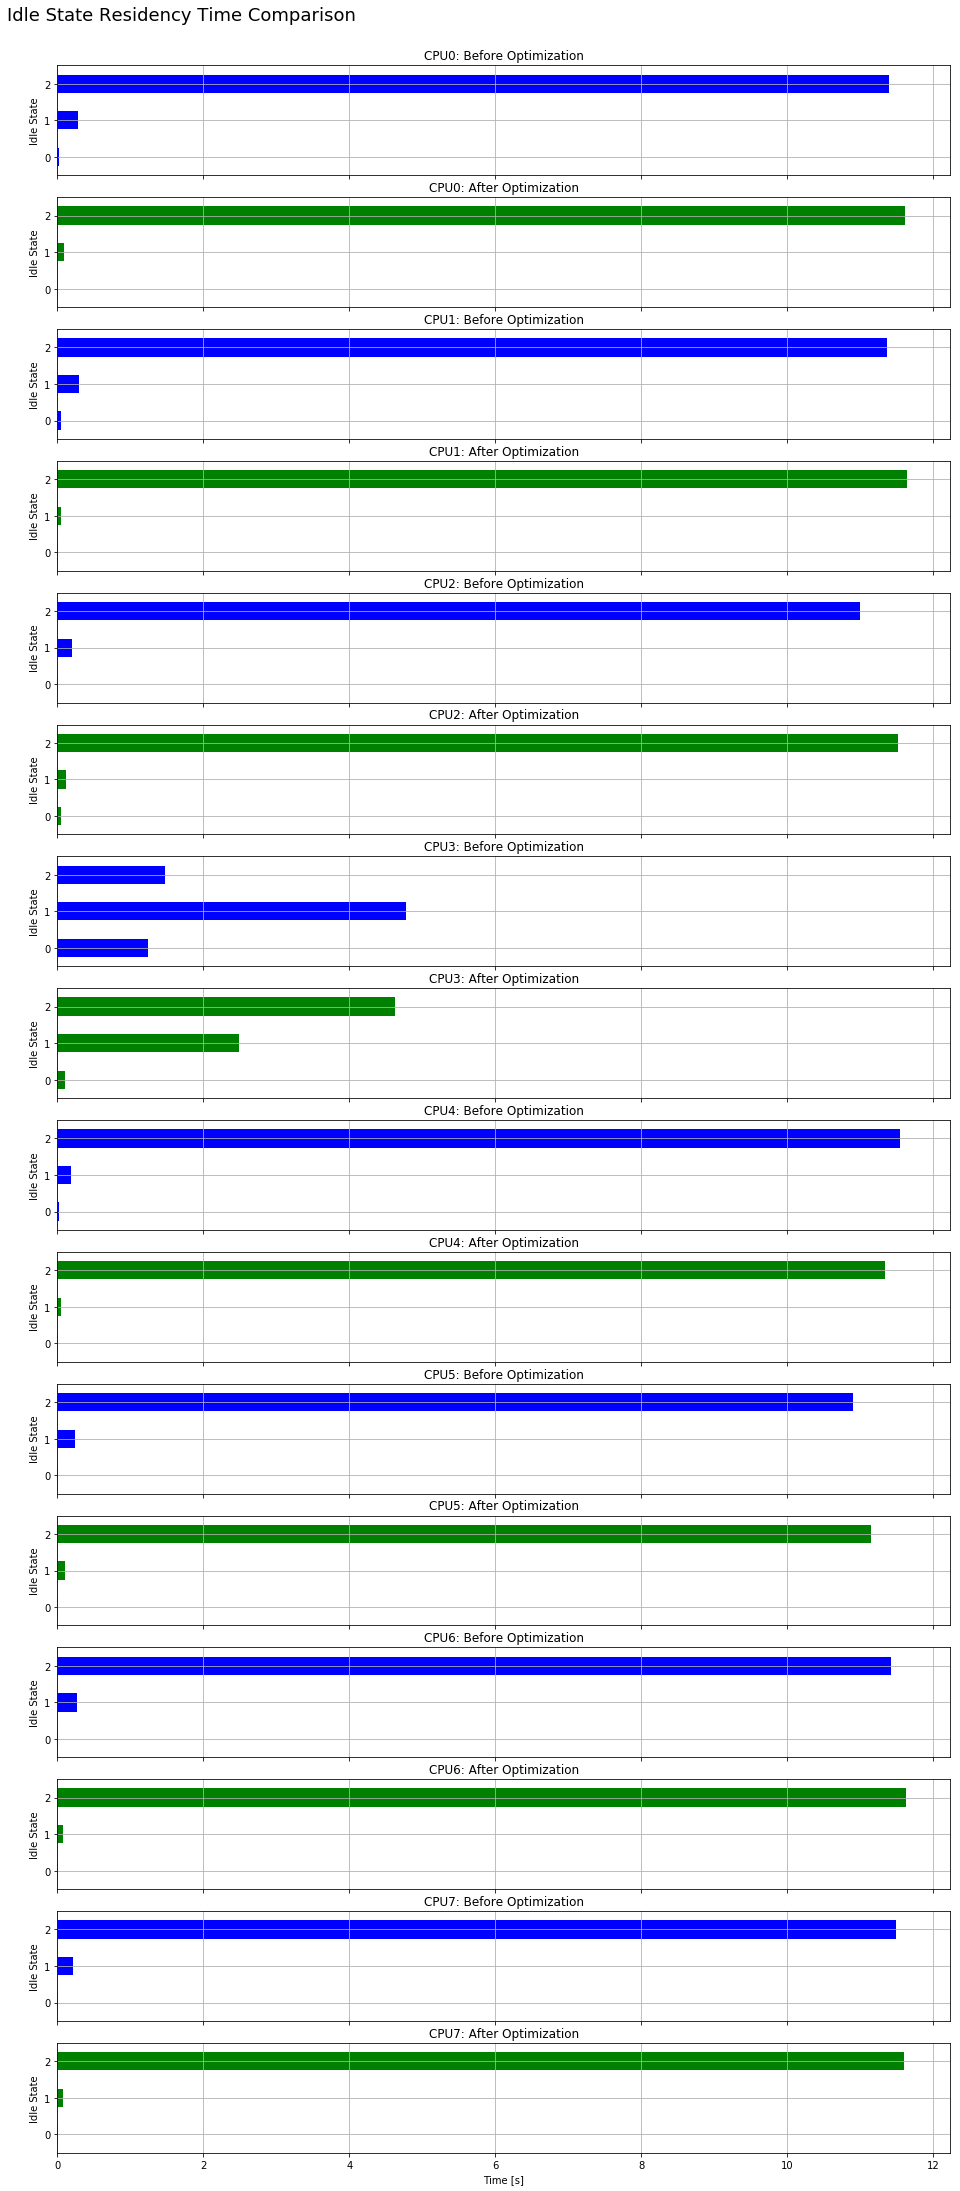

In [78]:
plotCPUIdleStateResidencyComparison(prev_ia, post_ia)

In [79]:
df = dfAllCPUIdleStateEstimationStatisticsDiff(prev_ia, post_ia, [ 1, 1000, 2700, 10000000000 ])
df

,cpu,good_est,over_est,under_est,cpu,good_est,over_est,under_est,cpu,good_est,over_est,under_est
0,0,33,0,5,0,44,0,5,0,11,0,0
1,0,13,19,67,0,5,21,20,0,-8,2,-47
2,0,105,215,0,0,211,215,0,0,106,0,0
0,1,155,0,13,1,15,0,3,0,-140,0,-10
1,1,16,9,70,1,9,8,10,0,-7,-1,-60
2,1,66,31,0,1,112,42,0,0,46,11,0
0,2,7,0,6,2,105,0,14,0,98,0,8
1,2,10,7,49,2,13,26,25,0,3,19,-24
2,2,84,13,0,2,74,29,0,0,-10,16,0
0,3,1017,0,510,3,760,0,4,0,-257,0,-506
